In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 33.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-nytf048t
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-nytf048t
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit e9648df16dcb6dde0e09b5736b1b2da5d68db2ad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
from statistics import mean
import torch_geometric
from torch_geometric.datasets import TUDataset
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn
from torch.autograd import graph
from typing import Any, Dict, Optional, Union
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
from importlib import reload
import pickle
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from torch_geometric.data import Data, Batch, Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mutag_dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
Explainability_name = 'Run All Methods'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
DataSet_name = "MUTAG"

#File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes_MUTAG.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [7]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

mutag_train_dataset = []
mutag_test_dataset = []
for index in read_training_list_indexes:
    mutag_train_dataset.append(mutag_dataset[index])
for index in read_test_list_indexes:
    mutag_test_dataset.append(mutag_dataset[index])


print(f'Number of training graphs: {len(mutag_train_dataset)}')
print(f'Number of test graphs: {len(mutag_test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [8]:
BATCH_SIZE = 64
mutag_train_dataloader = DataLoader(mutag_train_dataset, batch_size=BATCH_SIZE, shuffle=False) # important to be false
mutag_test_dataloader = DataLoader(mutag_test_dataset, batch_size=1, shuffle=False)

In [9]:
print(mutag_train_dataloader.batch_size)
batch = next(iter(mutag_train_dataloader))
print(batch.y)
print(len(mutag_train_dataloader))

64
tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1])
3


In [10]:
# from torch_geometric.datasets import FakeDataset

# num_graphs = 100
# avg_num_nodes = 20
# avg_degree = 15
# node_feat_dim = 13
# edge_feat_dim = 0
# num_classes = 3

# fake_dataset = FakeDataset(num_graphs=num_graphs, avg_num_nodes=avg_num_nodes, avg_degree=avg_degree, num_channels=node_feat_dim,
#                            edge_dim=edge_feat_dim, num_classes=num_classes,)
# Explainability_name = 'PGExplainer'
# Task_name = 'Graph Classification'
# classifier_bias = True
# DataSet_name = "Fake"
# BATCH_SIZE = 10
# classifier_lr = 0.001
# classifier_dropout = 0.1
# classifier_weight_decay = 1e-6

# train_ratio = 0.8

# fake_train_dataset = fake_dataset[:int(len(fake_dataset) * train_ratio)]
# fake_test_dataset = fake_dataset[len(fake_dataset) - int(len(fake_dataset) * train_ratio):]

# fake_train_dataloader = DataLoader(fake_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# fake_test_dataloader = DataLoader(fake_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

directory = "/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/"

with open(directory + 'fake_train_dataset.pkl', 'rb') as f:
    fake_train_dataset = pickle.load(f)

with open(directory + 'fake_test_dataset.pkl', 'rb') as f:
    fake_test_dataset = pickle.load(f)

with open(directory + 'fake_train_dataloader.pkl', 'rb') as f:
    fake_train_dataloader = pickle.load(f)

with open(directory + 'fake_test_dataloader.pkl', 'rb') as f:
    fake_test_dataloader = pickle.load(f)

In [47]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)

#import GCN_plus_GAP as Graph_Network
#GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
#                                       num_hid_layers=3, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
#                                       dropout_rate=classifier_dropout)

#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, node_feat_size=7, mlp_act_fun='ReLu',
#                                    dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=17,
#                                    hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

#import DIFFPOOL as diffpool_model
#GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
#                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
#                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
#                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
#                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
#                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")

import GIN as gin_model
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, mlp_input_dim=13, mlp_hid_dim=13, mlp_output_dim=3, num_slp_layers=2,
                                Bias=classifier_bias, mlp_act_fun="ReLu", dropout_rate=classifier_dropout, Weight_Initializer=1,
                                joint_embeddings=False)



Model_name = GNN_Model.__class__.__name__

In [28]:
print(GNN_Model)

GIN_Model(
  (gin_mlp_layers): ModuleList(
    (0-3): 4 x GIN_MLPs(
      (gin_mlp_layers): ModuleList(
        (0-1): 2 x Linear(in_features=7, out_features=7, bias=True)
      )
      (gin_batch_normalization): ModuleList(
        (0-1): 2 x BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (global_summing): GlobalSUMPool()
  (the_first_layer): Linear(in_features=7, out_features=7, bias=True)
  (lin1): Linear(in_features=7, out_features=7, bias=True)
  (lin2): Linear(in_features=7, out_features=2, bias=True)
  (dorpout): Dropout(p=0.1, inplace=False)
)


In [48]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [15]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

In [16]:
def train_step(data):
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in data:
        if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
            batch_loss = loss_calculations(soft, batch_of_graphs.y)
            Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
            Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, prediction_output_not_softed, prediction_output = GNN_Model(batch_of_graphs, None)
            Pred_Labels.extend(prediction_output.argmax(dim=1).detach().tolist())
            batch_loss = loss_calculations(prediction_output, batch_of_graphs.y)

        elif GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(lin2_output_softmaxed, batch_of_graphs.y)
            Pred_Labels.extend(lin2_output_softmaxed.argmax(dim=1).detach().tolist())
        else:
            raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [17]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index, data):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step(data)
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}, Accuracy: {training_acc:.2f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
        #  torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 1.1405, Accuracy: 0.39
Epoch: 002, Model Loss: 1.0844, Accuracy: 0.41
Epoch: 003, Model Loss: 0.9979, Accuracy: 0.54
Epoch: 004, Model Loss: 0.9681, Accuracy: 0.57
Epoch: 005, Model Loss: 0.9075, Accuracy: 0.62
Epoch: 006, Model Loss: 0.9357, Accuracy: 0.59
Epoch: 007, Model Loss: 0.8974, Accuracy: 0.64
Epoch: 008, Model Loss: 0.8738, Accuracy: 0.70
Epoch: 009, Model Loss: 0.7952, Accuracy: 0.75
Epoch: 010, Model Loss: 0.8168, Accuracy: 0.74
Epoch: 011, Model Loss: 0.8430, Accuracy: 0.71
Epoch: 012, Model Loss: 0.8338, Accuracy: 0.74
Epoch: 013, Model Loss: 0.7617, Accuracy: 0.80
Epoch: 014, Model Loss: 0.7309, Accuracy: 0.82
Epoch: 015, Model Loss: 0.7393, Accuracy: 0.81
Epoch: 016, Model Loss: 0.6762, Accuracy: 0.88
Epoch: 017, Model Loss: 0.6649, Accuracy: 0.90
Epoch: 018, Model Loss: 0.6517, Accuracy: 0.94
Epoch: 019, Model Loss: 0.6433, Accuracy: 0.93
Epoch: 020, Model Loss: 0.6193, Accuracy: 0.94
Epoch: 021, Model Loss: 0.5905, Accuracy: 0.96
Epoch: 022, M

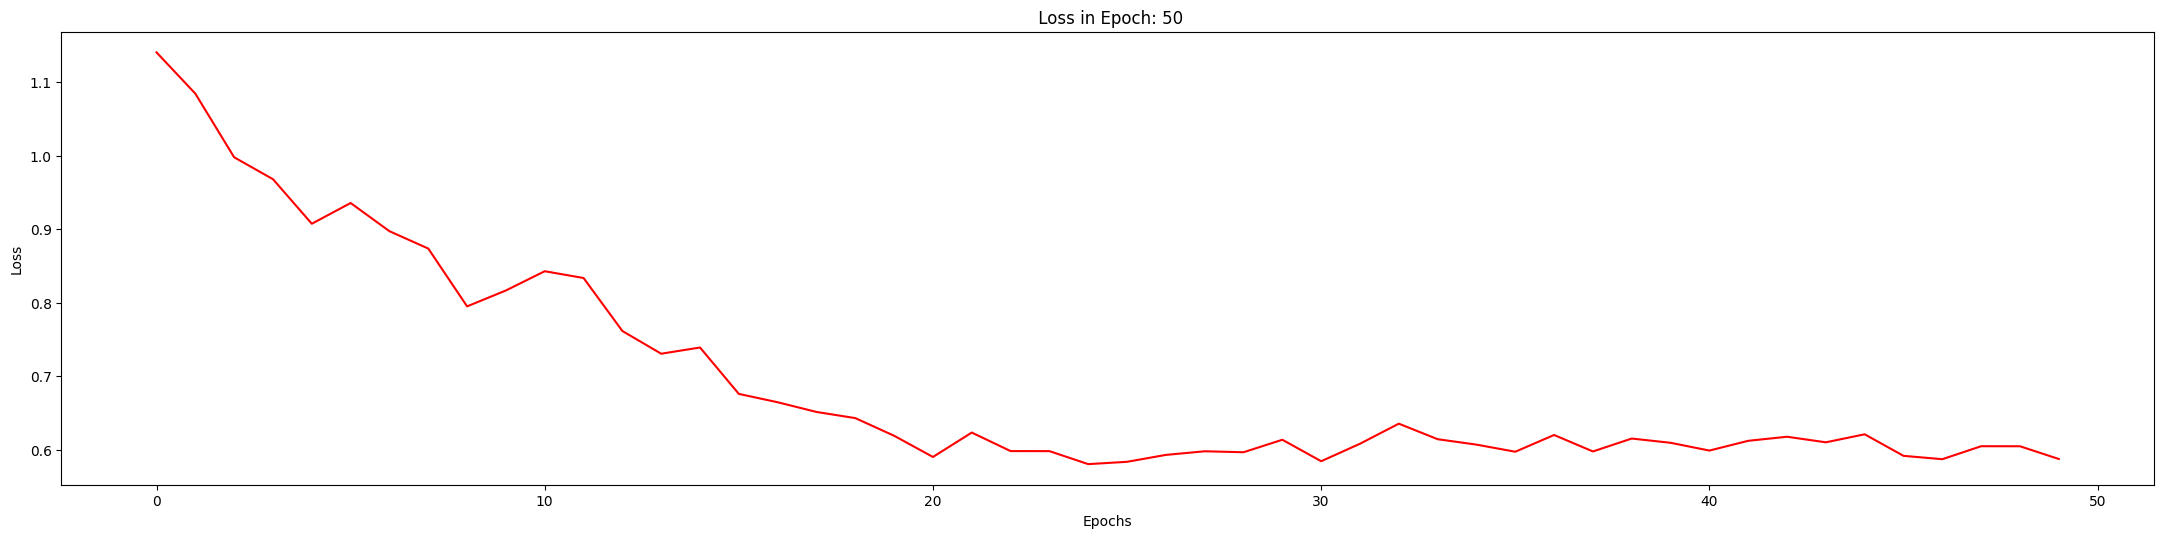

Epoch: 051, Model Loss: 0.5825, Accuracy: 0.97
Epoch: 052, Model Loss: 0.5790, Accuracy: 0.97
Epoch: 053, Model Loss: 0.5773, Accuracy: 0.97
Epoch: 054, Model Loss: 0.5842, Accuracy: 0.97
Epoch: 055, Model Loss: 0.5864, Accuracy: 0.97
Epoch: 056, Model Loss: 0.5815, Accuracy: 0.97
Epoch: 057, Model Loss: 0.5802, Accuracy: 0.97
Epoch: 058, Model Loss: 0.5770, Accuracy: 0.97
Epoch: 059, Model Loss: 0.5953, Accuracy: 0.95
Epoch: 060, Model Loss: 0.5801, Accuracy: 0.97
Epoch: 061, Model Loss: 0.5772, Accuracy: 0.97
Epoch: 062, Model Loss: 0.5789, Accuracy: 0.97
Epoch: 063, Model Loss: 0.5860, Accuracy: 0.96
Epoch: 064, Model Loss: 0.5778, Accuracy: 0.97
Epoch: 065, Model Loss: 0.5796, Accuracy: 0.97
Epoch: 066, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 067, Model Loss: 0.5768, Accuracy: 0.97
Epoch: 068, Model Loss: 0.5767, Accuracy: 0.97
Epoch: 069, Model Loss: 0.5768, Accuracy: 0.97
Epoch: 070, Model Loss: 0.5797, Accuracy: 0.97
Epoch: 071, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 072, M

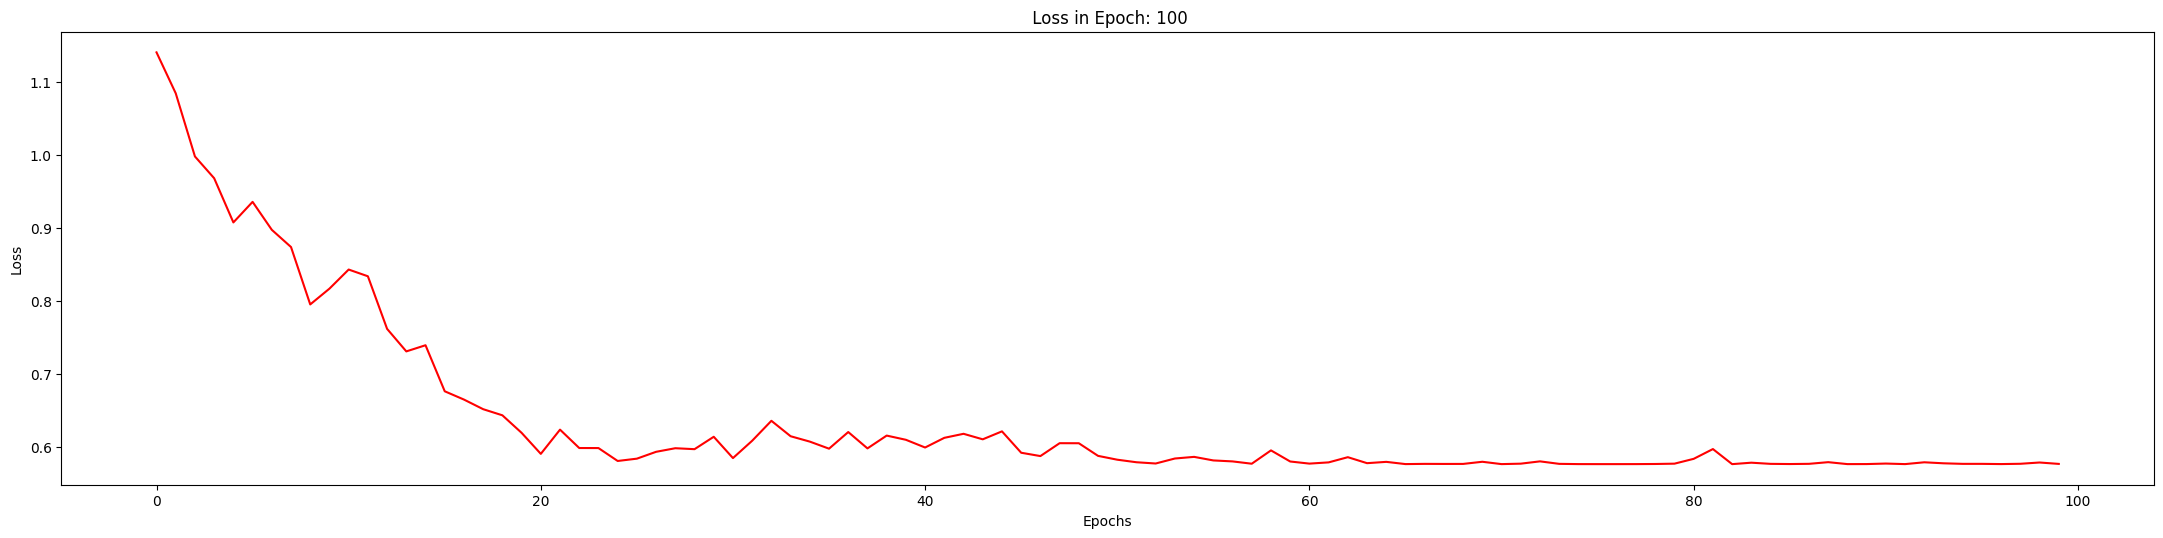

Epoch: 101, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 102, Model Loss: 0.5786, Accuracy: 0.97
Epoch: 103, Model Loss: 0.5769, Accuracy: 0.97
Epoch: 104, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 105, Model Loss: 0.5803, Accuracy: 0.97
Epoch: 106, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 107, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 108, Model Loss: 0.5773, Accuracy: 0.97
Epoch: 109, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 110, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 111, Model Loss: 0.5875, Accuracy: 0.96
Epoch: 112, Model Loss: 0.5766, Accuracy: 0.97
Epoch: 113, Model Loss: 0.5769, Accuracy: 0.97
Epoch: 114, Model Loss: 0.5802, Accuracy: 0.97
Epoch: 115, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 116, Model Loss: 0.5766, Accuracy: 0.97
Epoch: 117, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 118, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 119, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 120, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 121, Model Loss: 0.5767, Accuracy: 0.97
Epoch: 122, M

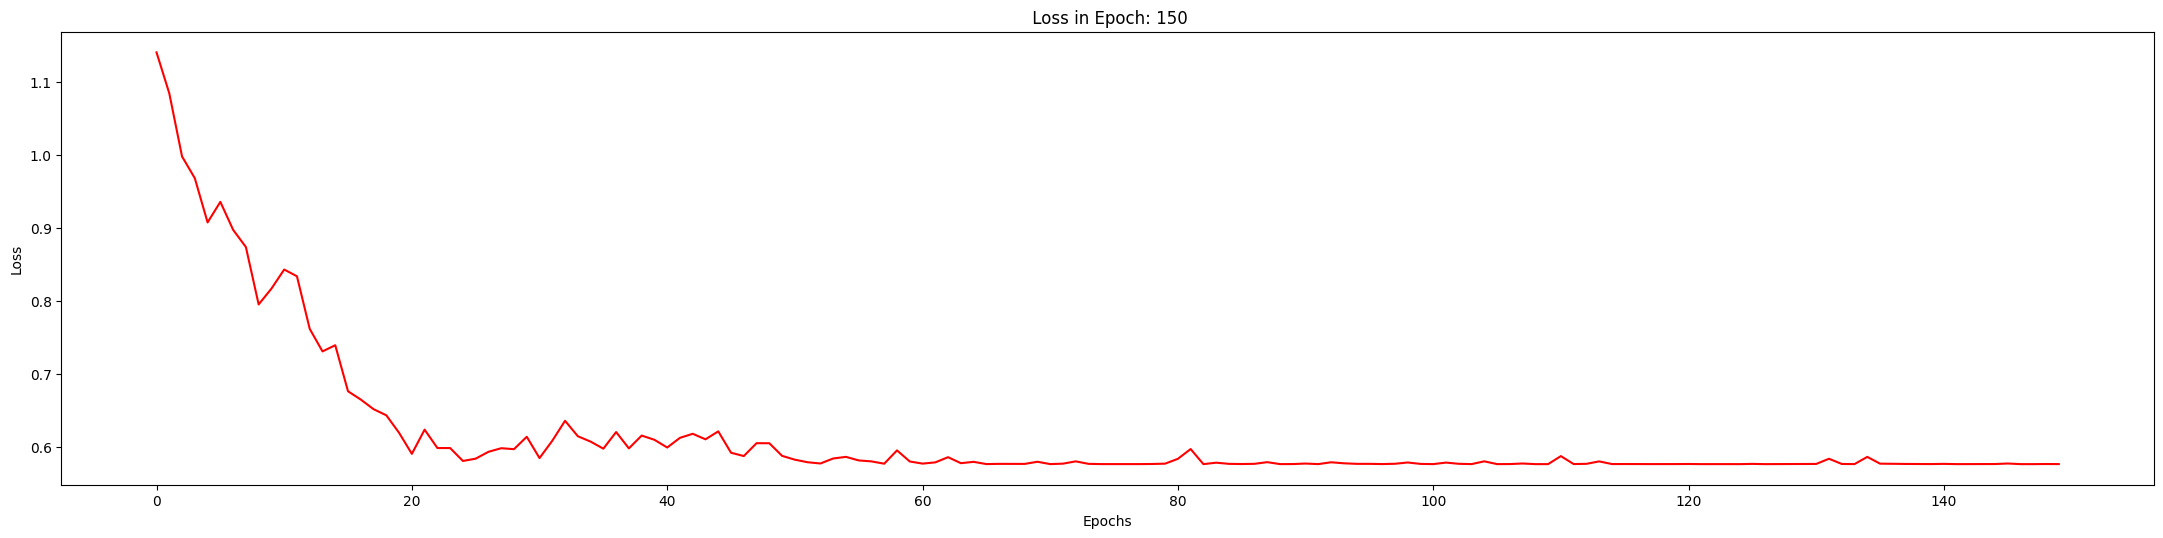

Epoch: 151, Model Loss: 0.5773, Accuracy: 0.97
Epoch: 152, Model Loss: 0.5822, Accuracy: 0.96
Epoch: 153, Model Loss: 0.5768, Accuracy: 0.97
Epoch: 154, Model Loss: 0.5828, Accuracy: 0.97
Epoch: 155, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 156, Model Loss: 0.5811, Accuracy: 0.97
Epoch: 157, Model Loss: 0.5766, Accuracy: 0.97
Epoch: 158, Model Loss: 0.5865, Accuracy: 0.96
Epoch: 159, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 160, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 161, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 162, Model Loss: 0.5766, Accuracy: 0.97
Epoch: 163, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 164, Model Loss: 0.5770, Accuracy: 0.97
Epoch: 165, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 166, Model Loss: 0.5795, Accuracy: 0.97
Epoch: 167, Model Loss: 0.5773, Accuracy: 0.97
Epoch: 168, Model Loss: 0.5848, Accuracy: 0.96
Epoch: 169, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 170, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 171, Model Loss: 0.5769, Accuracy: 0.97
Epoch: 172, M

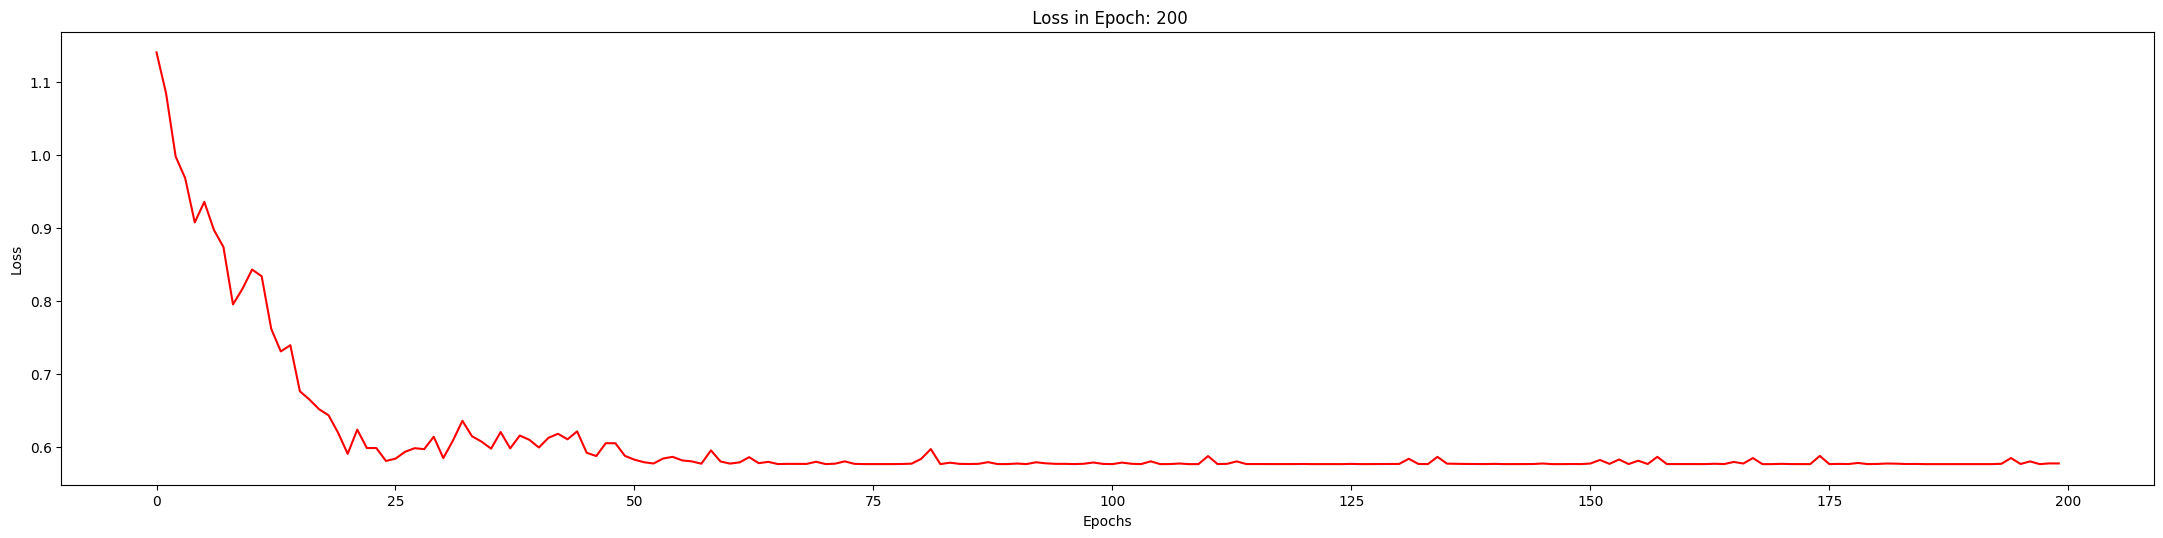

Epoch: 201, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 202, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 203, Model Loss: 0.5773, Accuracy: 0.97
Epoch: 204, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 205, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 206, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 207, Model Loss: 0.5771, Accuracy: 0.97
Epoch: 208, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 209, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 210, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 211, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 212, Model Loss: 0.5862, Accuracy: 0.96
Epoch: 213, Model Loss: 0.5797, Accuracy: 0.97
Epoch: 214, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 215, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 216, Model Loss: 0.5766, Accuracy: 0.97
Epoch: 217, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 218, Model Loss: 0.5766, Accuracy: 0.97
Epoch: 219, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 220, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 221, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 222, M

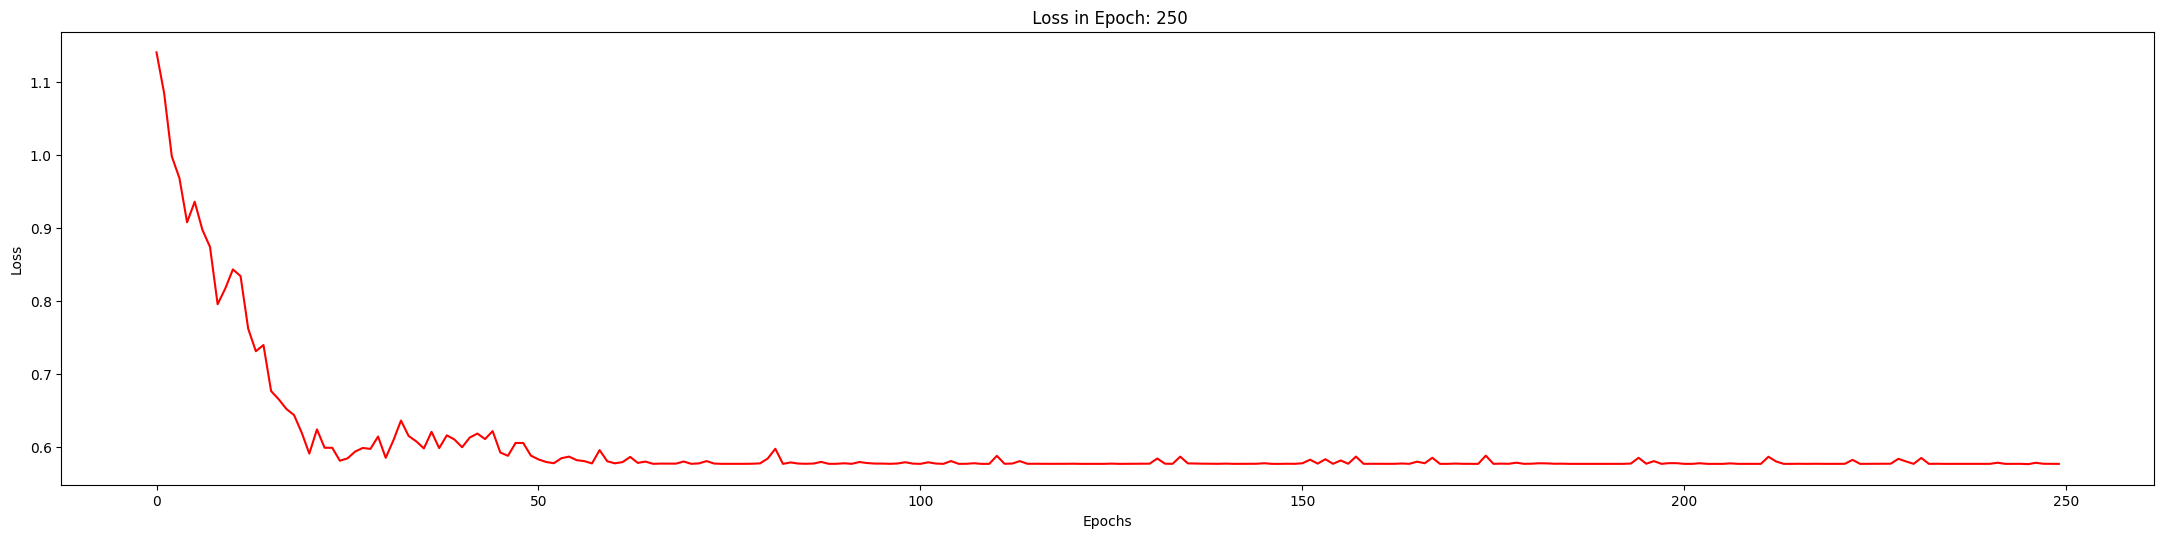

Epoch: 251, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 252, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 253, Model Loss: 0.5774, Accuracy: 0.97
Epoch: 254, Model Loss: 0.5770, Accuracy: 0.97
Epoch: 255, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 256, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 257, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 258, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 259, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 260, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 261, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 262, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 263, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 264, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 265, Model Loss: 0.5769, Accuracy: 0.97
Epoch: 266, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 267, Model Loss: 0.5764, Accuracy: 0.97
Epoch: 268, Model Loss: 0.5768, Accuracy: 0.97
Epoch: 269, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 270, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 271, Model Loss: 0.5765, Accuracy: 0.97
Epoch: 272, M

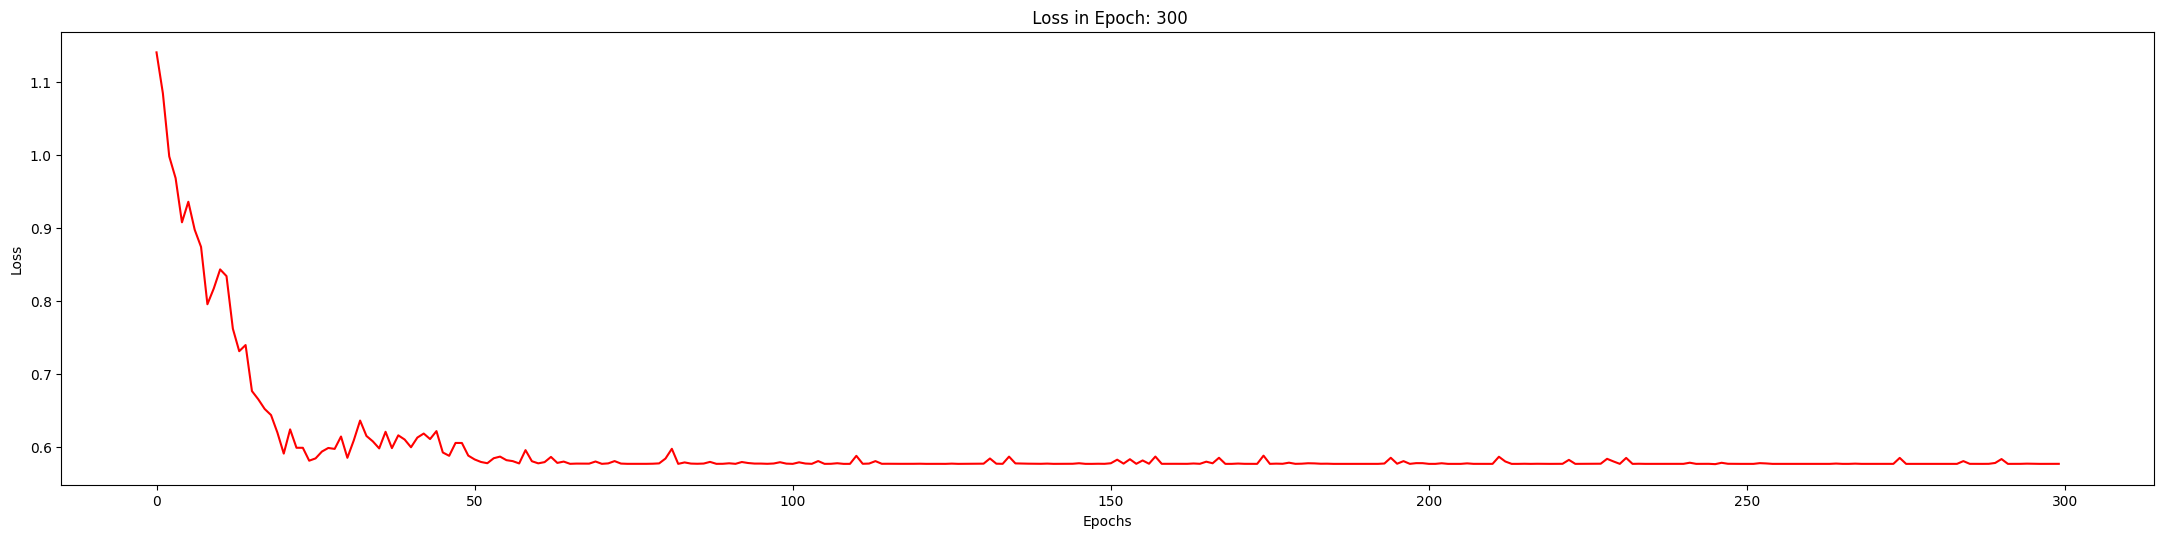

In [49]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index, fake_train_dataloader)

In [ ]:
random_tensor = torch.randint(2, (1, 10))
print(random_tensor.tolist())

In [ ]:
class profile_frequencies:
    def __init__(self, list_of_saliencies, test_dataset, style):
        self.list_of_saliencies = list_of_saliencies
        self.edges_profile_by_node_feats = {}
        self.edges_profile_by_node_feats_2_proportions = {}
        self.test_dataset = test_dataset
        self.style = style


        self.profile_edges_for_each_explanation()
        self.get_proportions()

        # for key, value in self.edges_profile_by_node_feats_2_proportions.items():
        #     print("Key: ", key, "      ", value)

    def profile_edges_for_each_explanation(self):
        for expl, graph in zip(self.list_of_saliencies, self.test_dataset):
            graph_edges = [(source_index, target_index) for source_index, target_index in graph.edge_index.T.tolist()]
            if self.style == "Edge":
                self.get_paired_features_as_keys_by_edge_saleincy(expl, graph_edges, graph.x)
            elif self.style == "Node":
                self.get_paired_features_as_keys_by_node_saleincy(expl, graph_edges, graph.x)

    def get_paired_features_as_keys_by_edge_saleincy(self, expl, edges, node_feats):
        for edge_sal, (source_index, target_index) in zip(expl, edges):
            if edge_sal == 1:
                edge_key = tuple([tuple(node_feats[source_index].tolist()), tuple(node_feats[target_index].tolist())])
                if edge_key in self.edges_profile_by_node_feats.keys():
                    self.edges_profile_by_node_feats[edge_key] = self.edges_profile_by_node_feats[edge_key] + 1
                else:
                    self.edges_profile_by_node_feats[edge_key] = 1

    def get_paired_features_as_keys_by_node_saleincy(self, expl, edges, node_feats):
        for (source_index, target_index) in edges:
            if (expl[source_index] == 1) and (expl[target_index] == 1):
                edge_key = tuple([tuple(node_feats[source_index].tolist()), tuple(node_feats[target_index].tolist())])
                if edge_key in self.edges_profile_by_node_feats.keys():
                    self.edges_profile_by_node_feats[edge_key] = self.edges_profile_by_node_feats[edge_key] + 1
                else:
                    self.edges_profile_by_node_feats[edge_key] = 1

    def get_proportions(self):
        sum_value = sum(self.edges_profile_by_node_feats.values())
        for key, value in self.edges_profile_by_node_feats.items():
            self.edges_profile_by_node_feats_2_proportions[key] = value/sum_value


    def profile_the_upcoming_explanation(self, an_explanation, a_graph):
        profile = []
        if self.style == "Edge":
            graph_edges = [(source_index, target_index) for source_index, target_index in a_graph.edge_index.T.tolist()]
            for sal_score, (source_index, target_index) in zip(an_explanation, graph_edges):
                edge_key = tuple([tuple(a_graph.x[source_index].tolist()), tuple(a_graph.x[target_index].tolist())])
                if sal_score == 1:
                    profile.append(self.edges_profile_by_node_feats_2_proportions[edge_key])
                else:
                    profile.append(0)
            return profile

        elif self.style == "Node":
            graph_edges = [(source_index, target_index) for source_index, target_index in a_graph.edge_index.T.tolist()]
            for (source_index, target_index) in graph_edges:
                edge_key = tuple([tuple(a_graph.x[source_index].tolist()), tuple(a_graph.x[target_index].tolist())])
                if (an_explanation[source_index] == 1) and (an_explanation[target_index] == 1):
                    profile.append(self.edges_profile_by_node_feats_2_proportions[edge_key])
                else:
                    profile.append(0)
            return profile

    def __call__(self, an_explanation, a_graph, threshold):

        profile = self.profile_the_upcoming_explanation(an_explanation, a_graph)
        profile_one_hot = [1 if value > threshold else 0 for value in profile]
        return profile_one_hot


# edge_explanations = []
# node_explanations = []
# number_of_graphs = 38
# for i in range(number_of_graphs):
#     edge_explanations.extend(torch.randint(2, (1, mutag_test_dataset[i].edge_index[0].size()[0])).tolist())
#     node_explanations.extend(torch.randint(2, (1, mutag_test_dataset[i].x.size()[0])).tolist())

# print("edge_explanations: ", edge_explanations)
# print("node_explanations: ", node_explanations)
# import random
# common_edges_finder = profile_frequencies(list_of_saliencies=edge_explanations, test_dataset=mutag_test_dataset[:number_of_graphs], style="Edge")
# graph_index = random.randint(1, 37)
# print(graph_index)
# profile_one_hot = common_edges_finder(edge_explanations[graph_index], mutag_test_dataset[graph_index], 0.7)
# print(" input graph number of nodes: ", len(mutag_test_dataset[graph_index].x), " input graph number of edges: ", len(mutag_test_dataset[graph_index].edge_index[0]))
# # for i, value in enumerate(profile_one_hot):
# #     print(i, "   ", value)
# print("profile_one_hot: ", len(profile_one_hot), profile_one_hot)

In [45]:
print(mutag_test_dataset[0].y.tolist()[0])

1


In [56]:
class one_model_one_explainer:
    def __init__(self, dataset_name):

        self.dataset_name = dataset_name
        self.fid_plus_threshold = 0.01
        self.fid_minus_threshold = 0.01
        self.contrastivity_threshold = 0.5
        self.sparsity_threshold = 0.5
        self.stability_threshold = 0.5
        self.stability_perturbation_mean = 0.1
        self.stability_perturbation_std = 0.1

    def avg_prediction_score(self, a_trained_GNN_Model, test_dataset, explanations, num_classes):
        # all explanations are in Edge style.
        predictions = {}
        for i in range(num_classes):
            predictions[i] = []

        # for class_index in range(num_classes):
        #     for input_graph, expl in zip(test_dataset, explanations[class_index]):
        #         graph = deepcopy(input_graph)
        #         graph_edges = [(source_index, target_index) for source_index, target_index in graph.edge_index.T.tolist()]
        #         for saliency, (source_index, target_index) in zip(expl, graph_edges):
        #             if saliency != 1:
        #                 graph.x[source_index] = torch.zeros_like(graph.x[source_index])
        #                 graph.x[target_index] = torch.zeros_like(graph.x[target_index])

        for i, input_graph in enumerate(test_dataset):
            expl = explanations[int(input_graph.y)][i]
            graph = deepcopy(input_graph)
            graph_edges = [(source_index, target_index) for source_index, target_index in graph.edge_index.T.tolist()]
            for saliency, (source_index, target_index) in zip(expl, graph_edges):
                if saliency != 1:
                    graph.x[source_index] = torch.zeros_like(graph.x[source_index])
                    graph.x[target_index] = torch.zeros_like(graph.x[target_index])

            if a_trained_GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, prediction = a_trained_GNN_Model(graph)
            elif a_trained_GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, prediction = a_trained_GNN_Model(graph, None)
            elif a_trained_GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, prediction_output_not_softed, prediction = a_trained_GNN_Model(graph, None)
            elif a_trained_GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, prediction = a_trained_GNN_Model(graph, None)
            else:
                raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")
            predictions[int(input_graph.y)].append(torch.squeeze(prediction).tolist()[int(input_graph.y)])
        return predictions


    def __call__(self, a_trained_GNN_Model, explainer_name, test_dataset, num_classes, explainer_epoch, explainer_learning_rate,
                 generalization_threshold):


        print("Name of the Dataset: ", self.dataset_name)
        print("Number of Classes: ", num_classes)
        print("Test Dataset Size: ", len(test_dataset))
        print("Explainer: ", explainer_name)
        print("Explainer Training Epochs: ", explainer_epoch)
        print("Explainer Learning Rate: ", explainer_learning_rate)

        ##########################################################################################################################

        if explainer_name == "GNNExplainer":
            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/GNNExplainer on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import gnnexplainer_on_graph_classification as GNNExplainer


            explanations = {}
            for i in range(num_classes):
                explanations[i] = []
            t1 = perf_counter()
            for i, graph in tqdm(enumerate(test_dataset)):
                for class_index in range(num_classes):
                    EXP = GNNExplainer.GNNExplainer(a_trained_GNN_Model, explainer_epoch, explainer_learning_rate)
                    node_mask, edge_mask = EXP(graph, class_index)
                    explanations[class_index].append(node_mask)

            timing = perf_counter()-t1
            average_explanation_time = (timing)/(num_classes*len(test_dataset))
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",  explainer_name, " average_explanation_time: ", average_explanation_time)

            # Adaptations
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_list = {}
            generalized_explanations_tensor = {}
            for i in range(num_classes):
                generalized_explanations_list[i] = []
                generalized_explanations_tensor[i] = []
            for key, class_explanations in explanations.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=test_dataset, style="Node")
                for expl, graph in zip(class_explanations, test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_list[key].append(profile_one_hot)
                    generalized_explanations_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            predictions = self.avg_prediction_score(a_trained_GNN_Model, test_dataset, generalized_explanations_list, num_classes)
            avg_prediction_scores = {}
            for key, value in predictions.items():
                avg_prediction_scores[key]=mean(value)
            print("avg_prediction_scores: ", avg_prediction_scores)

            #  Fidelity Plus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            eval_xai_fid_plus = reload(eval_xai_fid_plus)

            fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
                                                                                              test_data=test_dataset)
            fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                  importance_threshold=self.fid_plus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)


            #  Fidelity Minus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            eval_xai_fid_minus = reload(eval_xai_fid_minus)

            fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
                                                                                                 test_data=test_dataset)
            fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                    importance_threshold=self.fid_minus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)


            #  Contrastivity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            eval_xai_contrastivity = reload(eval_xai_contrastivity)

            contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
                                                                                                        test_data=test_dataset)
            contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
                                                                                 saliencies_for_multiple_classes=generalized_explanations_list,
                                                                                 importance_threshold=self.contrastivity_threshold, contrast_coeff=1e+11)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)


            #  Sparsity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            eval_xai_sparsity = reload(eval_xai_sparsity)

            sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
                                                                                         test_data=test_dataset)
            sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
                                                                  saliencies_for_multiple_classes=generalized_explanations_list,
                                                                  importance_threshold=self.sparsity_threshold)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)


            #  Stability
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_stability as eval_xai_stability
            eval_xai_stability = reload(eval_xai_stability)

            stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model, test_data=test_dataset)
            perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean, self.stability_perturbation_std)

            explanations_for_perturbed_data_list = {}
            for i in range(num_classes):
                explanations_for_perturbed_data_list[i] = []
            for graph in perturbed_test_dataset:
                for class_index in range(num_classes):
                    EXP = GNNExplainer.GNNExplainer(a_trained_GNN_Model, explainer_epoch, explainer_learning_rate)
                    node_mask, edge_mask = EXP(graph, class_index)
                    explanations_for_perturbed_data_list[class_index].append(node_mask)

                # Adaptations for perturbed data
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_for_perturbed_data_list = {}
            generalized_explanations_for_perturbed_data_tensor = {}
            for i in range(num_classes):
                generalized_explanations_for_perturbed_data_list[i] = []
                generalized_explanations_for_perturbed_data_tensor[i] = []

            for key, class_explanations in explanations_for_perturbed_data_list.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=perturbed_test_dataset, style="Node")
                for expl, graph in zip(class_explanations, perturbed_test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_for_perturbed_data_list[key].append(profile_one_hot)
                    generalized_explanations_for_perturbed_data_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=generalized_explanations_list,
                                                     perturbed_saliencies_for_multiple_classes=generalized_explanations_for_perturbed_data_list,
                                                     top_k_features=2, importance_threshold=self.stability_threshold, style='Edge')
            print(a_trained_GNN_Model.__class__.__name__, " Model by ", explainer_name, " Stability_Score: ", stability_score)





            ######################################################################################################################

        elif explainer_name == "PGExplainer":

            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/PGExplainer on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import pgexplainer_on_graph_classification as PGExplainer_Module
            PGExplainer_Module = reload(PGExplainer_Module)

            explanations_list = {}
            explanations_tensor = {}
            for i in range(num_classes):
                explanations_list[i] = []
                explanations_tensor[i] = []
            pgex_t1 = perf_counter()
            for class_index in tqdm(range(num_classes)):

                ExTrain_or_ExTest = 'train'
                EXP = PGExplainer_Module.PGExplainer(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                     Exp_Epoch=explainer_epoch, Exp_lr=explainer_learning_rate,
                                                     node_feat_dim=test_dataset[0].x[0].size()[0])

                EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=test_dataset,
                    target_class=class_index)

                ExTrain_or_ExTest = 'test'
                EXP = PGExplainer_Module.PGExplainer(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                     Exp_Epoch=explainer_epoch, Exp_lr=explainer_learning_rate,
                                                     node_feat_dim=test_dataset[0].x[0].size()[0])
                for graph in test_dataset:
                    edge_mask = EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=[graph],
                                     target_class=class_index)
                    explanations_list[class_index].append(edge_mask[0].tolist())
                    explanations_tensor[class_index].append(edge_mask[0])
            pgex_timing = perf_counter()-pgex_t1
            average_explanation_time = (pgex_timing)/(num_classes*len(test_dataset))
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",  explainer_name, " average_explanation_time: ", average_explanation_time)

                # Adaptations
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_list = {}
            generalized_explanations_tensor = {}
            for i in range(num_classes):
                generalized_explanations_list[i] = []
                generalized_explanations_tensor[i] = []
            for key, class_explanations in explanations_tensor.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=test_dataset, style="Edge")
                for expl, graph in zip(class_explanations, test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_list[key].append(profile_one_hot)
                    generalized_explanations_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            predictions = self.avg_prediction_score(a_trained_GNN_Model, test_dataset, generalized_explanations_list, num_classes)
            avg_prediction_scores = {}
            for key, value in predictions.items():
                avg_prediction_scores[key]=mean(value)
            print("avg_prediction_scores: ", avg_prediction_scores)

            #  Fidelity Plus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            eval_xai_fid_plus = reload(eval_xai_fid_plus)

            fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
                                                                                              test_data=test_dataset)
            fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                  importance_threshold=self.fid_plus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)


            #  Fidelity Minus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            eval_xai_fid_minus = reload(eval_xai_fid_minus)

            fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
                                                                                                 test_data=test_dataset)
            fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                    importance_threshold=self.fid_minus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)


            #  Contrastivity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            eval_xai_contrastivity = reload(eval_xai_contrastivity)

            contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
                                                                                                        test_data=test_dataset)
            contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
                                                                                 saliencies_for_multiple_classes=generalized_explanations_list,
                                                                                 importance_threshold=self.contrastivity_threshold,
                                                                                 contrast_coeff=1e+11)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)


            #  Sparsity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            eval_xai_sparsity = reload(eval_xai_sparsity)

            sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
                                                                                         test_data=test_dataset)
            sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
                                                                  saliencies_for_multiple_classes=generalized_explanations_list,
                                                                  importance_threshold=self.sparsity_threshold)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)


            #  Stability
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_stability as eval_xai_stability
            eval_xai_stability = reload(eval_xai_stability)

            stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model, test_data=test_dataset)
            perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean, self.stability_perturbation_std)

            explanations_for_perturbed_data_list = {}
            for i in range(num_classes):
                explanations_for_perturbed_data_list[i] = []

            for class_index in range(num_classes):

                ExTrain_or_ExTest = 'train'
                EXP = PGExplainer_Module.PGExplainer(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                     Exp_Epoch=explainer_epoch, Exp_lr=explainer_learning_rate,
                                                     node_feat_dim=test_dataset[0].x[0].size()[0])

                EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=test_dataset,
                    target_class=class_index)

                ExTrain_or_ExTest = 'test'
                EXP = PGExplainer_Module.PGExplainer(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                     Exp_Epoch=explainer_epoch, Exp_lr=explainer_learning_rate,
                                                     node_feat_dim=test_dataset[0].x[0].size()[0])
                for graph in perturbed_test_dataset:
                    edge_mask = EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=[graph],
                                     target_class=class_index)
                    explanations_for_perturbed_data_list[class_index].append(edge_mask[0])

                # Adaptations for perturbed data
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_for_perturbed_data_list = {}
            generalized_explanations_for_perturbed_data_tensor = {}
            for i in range(num_classes):
                generalized_explanations_for_perturbed_data_list[i] = []
                generalized_explanations_for_perturbed_data_tensor[i] = []

            for key, class_explanations in explanations_for_perturbed_data_list.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=perturbed_test_dataset, style="Edge")
                for expl, graph in zip(class_explanations, perturbed_test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_for_perturbed_data_list[key].append(profile_one_hot)
                    generalized_explanations_for_perturbed_data_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=generalized_explanations_list,
                                                     perturbed_saliencies_for_multiple_classes=generalized_explanations_for_perturbed_data_list,
                                                     top_k_features=2, importance_threshold=self.stability_threshold, style='Edge')
            print(a_trained_GNN_Model.__class__.__name__, " Model by ", explainer_name, " Stability_Score: ", stability_score)



            ######################################################################################################################

        elif explainer_name == "GraphMask":

            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/GraphMask on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import graphmask_on_graph_classification as GraphMask_Module
            GraphMask_Module = reload(GraphMask_Module)

            explanations_list = {}
            explanations_tensor = {}
            for i in range(num_classes):
                explanations_list[i] = []
                explanations_tensor[i] = []
            pgex_t1 = perf_counter()
            for class_index in tqdm(range(num_classes)):

                ExTrain_or_ExTest = 'train'
                EXP = GraphMask_Module.GraphMask(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                 Exp_Epoch=explainer_epoch, Exp_lr=0.001, explainer_hid_dim=test_dataset[0].x[0].size()[0],
                                                 node_feat_dim=test_dataset[0].x[0].size()[0])

                EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=test_dataset,
                    target_class=class_index)

                ExTrain_or_ExTest = 'test'
                EXP = GraphMask_Module.GraphMask(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                 Exp_Epoch=explainer_epoch, Exp_lr=0.001, explainer_hid_dim=test_dataset[0].x[0].size()[0],
                                                 node_feat_dim=test_dataset[0].x[0].size()[0])
                for graph in test_dataset:
                    edge_mask = EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=[graph],
                                     target_class=class_index)
                    explanations_list[class_index].append(edge_mask[0].tolist())
                    explanations_tensor[class_index].append(edge_mask[0])
            pgex_timing = perf_counter()-pgex_t1
            average_explanation_time = (pgex_timing)/(num_classes*len(test_dataset))
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",  explainer_name, " average_explanation_time: ", average_explanation_time)

                # Adaptations
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_list = {}
            generalized_explanations_tensor = {}
            for i in range(num_classes):
                generalized_explanations_list[i] = []
                generalized_explanations_tensor[i] = []
            for key, class_explanations in explanations_tensor.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=test_dataset, style="Edge")
                for expl, graph in zip(class_explanations, test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_list[key].append(profile_one_hot)
                    generalized_explanations_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            predictions = self.avg_prediction_score(a_trained_GNN_Model, test_dataset, generalized_explanations_list, num_classes)
            avg_prediction_scores = {}
            for key, value in predictions.items():
                avg_prediction_scores[key]=mean(value)
            print("avg_prediction_scores: ", avg_prediction_scores)


            #  Fidelity Plus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            eval_xai_fid_plus = reload(eval_xai_fid_plus)

            fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
                                                                                              test_data=test_dataset)
            fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                  importance_threshold=self.fid_plus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)


            #  Fidelity Minus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            eval_xai_fid_minus = reload(eval_xai_fid_minus)

            fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
                                                                                                 test_data=test_dataset)
            fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                    importance_threshold=self.fid_minus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)


            #  Contrastivity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            eval_xai_contrastivity = reload(eval_xai_contrastivity)

            contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
                                                                                                        test_data=test_dataset)
            contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
                                                                                 saliencies_for_multiple_classes=generalized_explanations_list,
                                                                                 importance_threshold=self.contrastivity_threshold,
                                                                                 contrast_coeff=1e+11)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)


            #  Sparsity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            eval_xai_sparsity = reload(eval_xai_sparsity)

            sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
                                                                                         test_data=test_dataset)
            sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
                                                                  saliencies_for_multiple_classes=generalized_explanations_list,
                                                                  importance_threshold=self.sparsity_threshold)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)



            #  Stability
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_stability as eval_xai_stability
            eval_xai_stability = reload(eval_xai_stability)

            stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model, test_data=test_dataset)
            perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean, self.stability_perturbation_std)

            explanations_for_perturbed_data_list = {}
            for i in range(num_classes):
                explanations_for_perturbed_data_list[i] = []

            for class_index in range(num_classes):

                ExTrain_or_ExTest = 'train'
                EXP = GraphMask_Module.GraphMask(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                 Exp_Epoch=explainer_epoch, Exp_lr=0.001, explainer_hid_dim=test_dataset[0].x[0].size()[0],
                                                 node_feat_dim=test_dataset[0].x[0].size()[0])

                EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=test_dataset,
                    target_class=class_index)

                ExTrain_or_ExTest = 'test'
                EXP = GraphMask_Module.GraphMask(GNN_Model=a_trained_GNN_Model, explainer_save_index=explainer_epoch,
                                                 Exp_Epoch=explainer_epoch, Exp_lr=0.001, explainer_hid_dim=test_dataset[0].x[0].size()[0],
                                                 node_feat_dim=test_dataset[0].x[0].size()[0])
                for graph in perturbed_test_dataset:
                    edge_mask = EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=explainer_epoch, your_dataset=[graph],
                                     target_class=class_index)
                    explanations_for_perturbed_data_list[class_index].append(edge_mask[0])

            # Adaptations for perturbed data
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_for_perturbed_data_list = {}
            generalized_explanations_for_perturbed_data_tensor = {}
            for i in range(num_classes):
                generalized_explanations_for_perturbed_data_list[i] = []
                generalized_explanations_for_perturbed_data_tensor[i] = []

            for key, class_explanations in explanations_for_perturbed_data_list.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=perturbed_test_dataset, style="Edge")
                for expl, graph in zip(class_explanations, perturbed_test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_for_perturbed_data_list[key].append(profile_one_hot)
                    generalized_explanations_for_perturbed_data_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=generalized_explanations_list,
                                                     perturbed_saliencies_for_multiple_classes=generalized_explanations_for_perturbed_data_list,
                                                     top_k_features=2, importance_threshold=self.stability_threshold, style='Edge')
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Stability_Score: ", stability_score)





            ######################################################################################################################

        elif explainer_name == "SubGraphX":
            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/SubGraphX on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import subgraphx_on_graph_classification_final_format as SubGraphX_Module
            SubGraphX_Module = reload(SubGraphX_Module)

            Train_or_Test='test'
            if Train_or_Test == 'train':
                SubGX = SubGraphX_Module.SubGraphX(GNN_Model=GNN_Model, num_classes=num_classes, num_hops=2, explain_graph=True,
                                                rollout_count=20, min_children_threshold=5, ubc1_c_coef= 10.0,
                                                expand_count_threshold=5, high2low=True, sample_num=100,
                                                save_permission_explanations= True, dataset_name=self.dataset_name)
                for i, graph in enumerate(test_dataset):
                    explanation_results, related_preds, time_list = SubGX(graph=graph, graph_index=i)
            elif Train_or_Test == 'test':
                subgx_out_the_fly = SubGraphX_Module.SubGraphX_off_the_fly(test_dataset=test_dataset, Task_name='Graph Classification',
                                                                           num_classes=num_classes, dataset_name=self.dataset_name,
                                                                           Model_Name=GNN_Model.__class__.__name__)
                whole_data = subgx_out_the_fly(test_dataset)

                explanations = {}
                for i in range(num_classes):
                    explanations[i] = []
                for cls in range(num_classes):
                    for i in range(len(test_dataset)):
                        explanations[cls].append(torch.sum(whole_data[i][cls]['important_nodes'].x, dim=1).tolist())
            # print("explanations: ", explanations)


            # Adaptations
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_list = {}
            generalized_explanations_tensor = {}
            for i in range(num_classes):
                generalized_explanations_list[i] = []
                generalized_explanations_tensor[i] = []
            for key, class_explanations in explanations.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=test_dataset, style="Node")
                for expl, graph in zip(class_explanations, test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_list[key].append(profile_one_hot)
                    generalized_explanations_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            predictions = self.avg_prediction_score(a_trained_GNN_Model, test_dataset, generalized_explanations_list, num_classes)
            avg_prediction_scores = {}
            for key, value in predictions.items():
                avg_prediction_scores[key]=mean(value)
            print("avg_prediction_scores: ", avg_prediction_scores)

            #  Fidelity Plus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            eval_xai_fid_plus = reload(eval_xai_fid_plus)

            fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
                                                                                              test_data=test_dataset)
            fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                  importance_threshold=self.fid_plus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)


            #  Fidelity Minus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            eval_xai_fid_minus = reload(eval_xai_fid_minus)

            fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
                                                                                                 test_data=test_dataset)
            fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                    importance_threshold=self.fid_minus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)


            #  Contrastivity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            eval_xai_contrastivity = reload(eval_xai_contrastivity)

            contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
                                                                                                        test_data=test_dataset)
            contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
                                                                                 saliencies_for_multiple_classes=generalized_explanations_list,
                                                                                 importance_threshold=self.contrastivity_threshold,
                                                                                 contrast_coeff=1e+11)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)


            #  Sparsity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            eval_xai_sparsity = reload(eval_xai_sparsity)

            sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
                                                                                         test_data=test_dataset)
            sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
                                                                  saliencies_for_multiple_classes=generalized_explanations_list,
                                                                  importance_threshold=self.sparsity_threshold)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)




            #  Stability
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_stability as eval_xai_stability
            eval_xai_stability = reload(eval_xai_stability)

            stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model, test_data=test_dataset)
            perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean,
                                                                                self.stability_perturbation_std)

            explanations_for_perturbed_data_list = {}
            for i in range(num_classes):
                explanations_for_perturbed_data_list[i] = []

            Train_or_Test_perturbed='test'
            if Train_or_Test_perturbed == 'train':
                SubGX = SubGraphX_Module.SubGraphX(GNN_Model=GNN_Model, num_classes=num_classes, num_hops=2, explain_graph=True,
                                                rollout_count=20, min_children_threshold=5, ubc1_c_coef= 10.0,
                                                expand_count_threshold=5, high2low=True, sample_num=100,
                                                save_permission_explanations= True, dataset_name="Perturbed_"+str(self.dataset_name))
                for i, graph in enumerate(perturbed_test_dataset):
                    explanation_results, related_preds, time_list = SubGX(graph=graph, graph_index=i)
            elif Train_or_Test_perturbed == 'test':
                subgx_out_the_fly = SubGraphX_Module.SubGraphX_off_the_fly(test_dataset=perturbed_test_dataset, Task_name='Graph Classification',
                                                                           num_classes=num_classes, dataset_name="Perturbed_"+str(self.dataset_name),
                                                                           Model_Name=GNN_Model.__class__.__name__)
                whole_data = subgx_out_the_fly(perturbed_test_dataset)

                for cls in range(num_classes):
                    for i in range(len(perturbed_test_dataset)):
                        explanations_for_perturbed_data_list[cls].append(torch.sum(whole_data[i][cls]['important_nodes'].x, dim=1).tolist())

            # Adaptations for perturbed data
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_for_perturbed_data_list = {}
            generalized_explanations_for_perturbed_data_tensor = {}
            for i in range(num_classes):
                generalized_explanations_for_perturbed_data_list[i] = []
                generalized_explanations_for_perturbed_data_tensor[i] = []

            for key, class_explanations in explanations_for_perturbed_data_list.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=perturbed_test_dataset, style="Node")
                for expl, graph in zip(class_explanations, perturbed_test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_for_perturbed_data_list[key].append(profile_one_hot)
                    generalized_explanations_for_perturbed_data_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=generalized_explanations_list,
                                                     perturbed_saliencies_for_multiple_classes=generalized_explanations_for_perturbed_data_list,
                                                     top_k_features=2, importance_threshold=self.stability_threshold, style='Edge')

            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Stability_Score: ", stability_score)


            ######################################################################################################################

        elif explainer_name == "CF2":
            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/CF2 on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import cf2_on_graph_classification_final_format as CF2_Module
            CF2_Module = reload(CF2_Module)
            explanations_tensor = {}
            explanations_list = {}
            for i in range(num_classes):
                explanations_tensor[i] = []
                explanations_list[i] = []
            for i in range(num_classes):
                cf2_explanation = CF2_Module.CF2_Explaination(GNN_Model=a_trained_GNN_Model, your_dataset=test_dataset,
                                                              explainer_epochs=explainer_epoch, fix_exp=None, input_dim=test_dataset[0].x[0].size()[0],
                                                              hid_dim=test_dataset[0].x[0].size()[0], output_dim=num_classes)
                exp_dict = cf2_explanation.explain_nodes_gnn_stats(category=i)
                for key, value in exp_dict.items():
                    explanations_tensor[i].append(value)
                    explanations_list[i].append(value.tolist())

            # Adaptations
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_list = {}
            generalized_explanations_tensor = {}
            for i in range(num_classes):
                generalized_explanations_list[i] = []
                generalized_explanations_tensor[i] = []
            for key, class_explanations in explanations_tensor.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=test_dataset, style="Node")
                for expl, graph in zip(class_explanations, test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_list[key].append(profile_one_hot)
                    generalized_explanations_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            predictions = self.avg_prediction_score(a_trained_GNN_Model, test_dataset, generalized_explanations_list, num_classes)
            avg_prediction_scores = {}
            for key, value in predictions.items():
                avg_prediction_scores[key]=mean(value)
            print("avg_prediction_scores: ", avg_prediction_scores)

            #  Fidelity Plus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            eval_xai_fid_plus = reload(eval_xai_fid_plus)

            fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
                                                                                              test_data=test_dataset)
            fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                  importance_threshold=self.fid_plus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)


            #  Fidelity Minus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            eval_xai_fid_minus = reload(eval_xai_fid_minus)

            fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
                                                                                                 test_data=test_dataset)
            fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                    importance_threshold=self.fid_minus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)


            #  Contrastivity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            eval_xai_contrastivity = reload(eval_xai_contrastivity)

            contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
                                                                                                        test_data=test_dataset)
            contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
                                                                                 saliencies_for_multiple_classes=generalized_explanations_list,
                                                                                 importance_threshold=self.contrastivity_threshold,
                                                                                 contrast_coeff=1e+11)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)


            #  Sparsity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            eval_xai_sparsity = reload(eval_xai_sparsity)

            sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
                                                                                         test_data=test_dataset)
            sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
                                                                  saliencies_for_multiple_classes=generalized_explanations_list,
                                                                  importance_threshold=self.sparsity_threshold)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)



            #  Stability
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_stability as eval_xai_stability
            eval_xai_stability = reload(eval_xai_stability)

            stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model,
                                                                            test_data=test_dataset)
            perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean,
                                                                                self.stability_perturbation_std)

            explanations_for_perturbed_data_list = {}
            for i in range(num_classes):
                explanations_for_perturbed_data_list[i] = []

            for i in range(num_classes):
                cf2_explanation = CF2_Module.CF2_Explaination(GNN_Model=a_trained_GNN_Model, your_dataset=perturbed_test_dataset,
                                                              explainer_epochs=explainer_epoch, fix_exp=None, input_dim=test_dataset[0].x[0].size()[0],
                                                              hid_dim=test_dataset[0].x[0].size()[0], output_dim=num_classes)
                exp_dict = cf2_explanation.explain_nodes_gnn_stats(category=i)
                for key, value in exp_dict.items():
                    explanations_for_perturbed_data_list[i].append(value)

            # Adaptations for perturbed data
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_for_perturbed_data_list = {}
            generalized_explanations_for_perturbed_data_tensor = {}
            for i in range(num_classes):
                generalized_explanations_for_perturbed_data_list[i] = []
                generalized_explanations_for_perturbed_data_tensor[i] = []

            for key, class_explanations in explanations_for_perturbed_data_list.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=perturbed_test_dataset, style="Node")
                for expl, graph in zip(class_explanations, perturbed_test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_for_perturbed_data_list[key].append(profile_one_hot)
                    generalized_explanations_for_perturbed_data_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=generalized_explanations_list,
                                                     perturbed_saliencies_for_multiple_classes=generalized_explanations_for_perturbed_data_list,
                                                     top_k_features=2, importance_threshold=self.stability_threshold, style='Edge')
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Stability_Score: ", stability_score)








            ######################################################################################################################

        elif explainer_name == "PGMExplainer":
            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/PGMExplainer on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import pgmexplainer_on_graph_classification_final_format as PGMExplainer_Module
            PGMExplainer_Module = reload(PGMExplainer_Module)

            explanations = {}
            for i in range(num_classes):
                explanations[i] = []
            for i in tqdm(range(num_classes)):
                for j in range(len(test_dataset)):

                    pgmx = PGMExplainer_Module.PGM_Graph_Explainer(GNN_Model=a_trained_GNN_Model, graph=test_dataset[j],
                                                                   perturb_feature_list=[None], perturb_mode = "mean",
                                                                   perturb_indicator = "abs")
                    pgm_node, p_values, candidate_nodes, dependent_nodes = pgmx.explain(num_samples=len(test_dataset[j].x),
                                                                                        noise_offset_percentage=50, top_node=5,
                                                                                        p_value_threshold=0.05, class_index=i)
                    test_graph = deepcopy(test_dataset[j])
                    for k in range(len(test_graph.x)):
                        if k not in pgm_node:
                            test_graph.x[k] = torch.zeros_like(test_graph.x[k])
                    graph_list = []
                    for node in test_graph.x:
                        graph_list.append(max(node).tolist())
                    explanations[i].append(graph_list)



            # Adaptations
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_list = {}
            generalized_explanations_tensor = {}
            for i in range(num_classes):
                generalized_explanations_list[i] = []
                generalized_explanations_tensor[i] = []
            for key, class_explanations in explanations.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=test_dataset, style="Node")
                for expl, graph in zip(class_explanations, test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_list[key].append(profile_one_hot)
                    generalized_explanations_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            predictions = self.avg_prediction_score(a_trained_GNN_Model, test_dataset, generalized_explanations_list, num_classes)
            avg_prediction_scores = {}
            for key, value in predictions.items():
                avg_prediction_scores[key]=mean(value)
            print("avg_prediction_scores: ", avg_prediction_scores)

            #  Fidelity Plus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            eval_xai_fid_plus = reload(eval_xai_fid_plus)

            fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
                                                                                              test_data=test_dataset)
            fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                  importance_threshold=self.fid_plus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)


            #  Fidelity Minus
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            eval_xai_fid_minus = reload(eval_xai_fid_minus)

            fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
                                                                                                 test_data=test_dataset)
            fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=generalized_explanations_tensor,
                                                                    importance_threshold=self.fid_minus_threshold, style="Edge")
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)




            #  Contrastivity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            eval_xai_contrastivity = reload(eval_xai_contrastivity)

            contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
                                                                                                        test_data=test_dataset)
            contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
                                                                                 saliencies_for_multiple_classes=generalized_explanations_list,
                                                                                 importance_threshold=self.contrastivity_threshold,
                                                                                 contrast_coeff=1e+11)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)


            #  Sparsity
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            eval_xai_sparsity = reload(eval_xai_sparsity)

            sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
                                                                                         test_data=test_dataset)
            sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
                                                                  saliencies_for_multiple_classes=generalized_explanations_list,
                                                                  importance_threshold=self.sparsity_threshold)
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)


            #  Stability
            py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            sys.path.insert(0,py_path)
            import evaluation_of_xmethods_stability as eval_xai_stability
            eval_xai_stability = reload(eval_xai_stability)

            stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model,
                                                                            test_data=test_dataset)
            perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean,
                                                                                self.stability_perturbation_std)

            explanations_for_perturbed_data_list = {}
            for i in range(num_classes):
                explanations_for_perturbed_data_list[i] = []

            for i in range(num_classes):
                for j in range(len(perturbed_test_dataset)):

                    pgmx = PGMExplainer_Module.PGM_Graph_Explainer(GNN_Model=a_trained_GNN_Model, graph=perturbed_test_dataset[j],
                                                                   perturb_feature_list=[None], perturb_mode = "mean",
                                                                   perturb_indicator = "abs")
                    pgm_node, p_values, candidate_nodes, dependent_nodes = pgmx.explain(num_samples=len(perturbed_test_dataset[j].x),
                                                                                        noise_offset_percentage=50, top_node=5,
                                                                                        p_value_threshold=0.05, class_index=i)
                    test_graph = deepcopy(perturbed_test_dataset[j])
                    for k in range(len(test_graph.x)):
                        if k not in pgm_node:
                            test_graph.x[k] = torch.zeros_like(test_graph.x[k])
                    graph_list = []
                    for node in test_graph.x:
                        graph_list.append(max(node).tolist())
                    explanations_for_perturbed_data_list[i].append(graph_list)

            # Adaptations for perturbed data
            py_path = '/content/drive/MyDrive/Explainability Methods/BottomUp Approach on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import bottomup_approach_for_global_methods as bottomup_isomorphism_scoring
            bottomup_isomorphism_scoring = reload(bottomup_isomorphism_scoring)
            generalized_explanations_for_perturbed_data_list = {}
            generalized_explanations_for_perturbed_data_tensor = {}
            for i in range(num_classes):
                generalized_explanations_for_perturbed_data_list[i] = []
                generalized_explanations_for_perturbed_data_tensor[i] = []

            for key, class_explanations in explanations_for_perturbed_data_list.items():
                common_edges_finder = bottomup_isomorphism_scoring.profile_frequencies(list_of_saliencies=class_explanations,
                                                                                       test_dataset=perturbed_test_dataset, style="Node")
                for expl, graph in zip(class_explanations, perturbed_test_dataset):
                    profile_one_hot = common_edges_finder(an_explanation=expl, a_graph=graph, threshold=generalization_threshold)
                    generalized_explanations_for_perturbed_data_list[key].append(profile_one_hot)
                    generalized_explanations_for_perturbed_data_tensor[key].append(torch.from_numpy(np.array(profile_one_hot)))

            stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=generalized_explanations_list,
                                            perturbed_saliencies_for_multiple_classes=generalized_explanations_for_perturbed_data_list,
                                            top_k_features=2, importance_threshold=self.sparsity_threshold, style='Edge')
            print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Stability_Score: ", stability_score)







            ######################################################################################################################

        elif explainer_name == "XGNN":
            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/XGNN on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import xgnn_on_graph_classification_final_format as XGNN_Module
            XGNN_Module = reload(XGNN_Module)
            mutag_max_number_of_nodes=38
            explanations = {}
            for i in range(num_classes):
                explanations[i] = []
            predictions = {}
            for i in range(num_classes):
                predictions[i] = []
            for cls_index in range(num_classes):
                xgnn_training = XGNN_Module.XGNN_training(GNN_Model=a_trained_GNN_Model, max_geneneration_iterations=10,
                                                          num_node_features=test_dataset[0].x[0].size()[0],
                                                          candidate_set_length=test_dataset[0].x[0].size()[0],
                                                          max_number_of_nodes=mutag_max_number_of_nodes,
                                                          random_start=True, rollout_count=10, class_of_explanation=cls_index,
                                                          hyp_for_rollout=1, hyp_for_rules=2, dropout_rate=0.5, explainer_lr=0.01,
                                                          b1=0.9, b2=0.999, weight_decay=5e-4)
                trained_graph = xgnn_training(explainer_epochs=explainer_epoch)
                explanation_graph = Data(x=trained_graph['feat'][:trained_graph['num_nodes']], edge_index=trained_graph['adj'], y=cls_index)

                if a_trained_GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, prediction = a_trained_GNN_Model(explanation_graph)
                elif a_trained_GNN_Model.__class__.__name__ == "DGCNN_Model":
                    final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, prediction = a_trained_GNN_Model(explanation_graph, None)
                elif a_trained_GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                    concatination_list_of_poolings, prediction_output_not_softed, prediction = a_trained_GNN_Model(explanation_graph, None)
                elif a_trained_GNN_Model.__class__.__name__ == "GIN_Model":
                    mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, prediction = a_trained_GNN_Model(explanation_graph, None)
                else:
                    raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")
                predictions[cls_index].append(torch.squeeze(prediction).tolist()[cls_index])
            print("predictions: ", predictions)




            # #  Fidelity Plus
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            # eval_xai_fid_plus = reload(eval_xai_fid_plus)

            # fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
            #                                                                                   test_data=test_dataset)
            # fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=explanations,
            #                                                       importance_threshold=self.fid_plus_threshold, style="Edge")
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)



            # #  Fidelity Minus
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            # eval_xai_fid_minus = reload(eval_xai_fid_minus)

            # fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
            #                                                                                      test_data=test_dataset)
            # fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=explanations,
            #                                                         importance_threshold=self.fid_minus_threshold, style="Edge")
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)



            # #  Contrastivity
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            # eval_xai_contrastivity = reload(eval_xai_contrastivity)

            # contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
            #                                                                                             test_data=test_dataset)
            # contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
            #                                                                      saliencies_for_multiple_classes=explanations,
            #                                                                      importance_threshold=self.contrastivity_threshold,
            #                                                                      contrast_coeff=1e+11)
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)




            # #  Sparsity
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            # eval_xai_sparsity = reload(eval_xai_sparsity)

            # sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
            #                                                                              test_data=test_dataset)
            # sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
            #                                                       saliencies_for_multiple_classes=explanations,
            #                                                       importance_threshold=self.sparsity_threshold)
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)





            # #  Stability
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_stability as eval_xai_stability
            # eval_xai_stability = reload(eval_xai_stability)

            # stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model,
            #                                                                 test_data=test_dataset)
            # perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean,
            #                                                                     self.stability_perturbation_std)

            # explanations_for_perturbed_data = {}
            # for i in range(num_classes):
            #     explanations_for_perturbed_data[i] = []

            # for cls_index in range(num_classes):
            #     xgnn_training = XGNN_Module.XGNN_training(GNN_Model=a_trained_GNN_Model, max_geneneration_iterations=10,
            #                                               num_node_features=test_dataset[0].x[0].size()[0],
            #                                               candidate_set_length=test_dataset[0].x[0].size()[0],
            #                                               max_number_of_nodes=mutag_max_number_of_nodes,
            #                                               random_start=True, rollout_count=10, class_of_explanation=cls_index,
            #                                               hyp_for_rollout=1, hyp_for_rules=2, dropout_rate=0.5, explainer_lr=0.01,
            #                                               b1=0.9, b2=0.999, weight_decay=5e-4)
            #     perturbed_trained_graph = xgnn_training(explainer_epochs=explainer_epoch)
            #     per_explanation_graph = Data(x=perturbed_trained_graph['feat'][:perturbed_trained_graph['num_nodes']], edge_index=perturbed_trained_graph['adj'], y=cls_index)
            #     py_path = '/content/drive/MyDrive/Explainability Methods/TopDown Approach on Graph Classification/Script/'
            #     sys.path.insert(0,py_path)
            #     import topdown_approach_for_global_methods as topdown_isomorphism_scoring
            #     topdown_isomorphism_scoring = reload(topdown_isomorphism_scoring)

            #     for i in range(len(perturbed_test_dataset)):
            #         common_edges_finder = topdown_isomorphism_scoring.global_explanation_and_samples_intersection(explanation=per_explanation_graph, input_graph=perturbed_test_dataset[i])
            #         perturbed_intersection_edges = common_edges_finder()
            #         explanations_for_perturbed_data[cls_index].append(torch.from_numpy(np.array(list(perturbed_intersection_edges.values()))))

            # stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=explanations,
            #                                          perturbed_saliencies_for_multiple_classes=explanations_for_perturbed_data,
            #                                          top_k_features=2, importance_threshold=self.stability_threshold, style='Edge')
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Stability_Score: ", stability_score)






            ######################################################################################################################

        elif explainer_name == "GNNInterpreter":
            import sys
            py_path = '/content/drive/MyDrive/Explainability Methods/GNNInterpreter on Graph Classification/Script/'
            sys.path.insert(0,py_path)
            import gnninterpreter_on_graph_classification_final_format as GNNInterpreter_Module




            explanations_size = {0:9, 1:7, 2:8}
            explanations = {}
            for i in range(num_classes):
                explanations[i] = []

            generations = {}
            for i in range(num_classes):
                generations[i] = []

            mean_of_node_embeddings = {}
            for i in range(num_classes):
                mean_of_node_embeddings[i] = torch.mean(torch.cat([graph.x for graph in test_dataset if graph.y == i], dim=0), axis=0)

            predictions = {}
            for i in range(num_classes):
                predictions[i] = []

            for cls_index in range(num_classes):
                losses_aggregated = GNNInterpreter_Module.losses_aggregation(
                    [
                        dict(key="continuous_generated_embeddings", criterion=GNNInterpreter_Module.Embedding_Loss_by_Cosine_Similarity(target_embedding=mean_of_node_embeddings[cls_index]), weight=10),
                        dict(key="discrete_generated_embeddings", criterion=GNNInterpreter_Module.Embedding_Loss_by_Cosine_Similarity(target_embedding=mean_of_node_embeddings[cls_index]), weight=10),
                        dict(key="logits_continuous", criterion=GNNInterpreter_Module.Explanation_Class_Score(class_idx=cls_index, mode='maximize'), weight=1),
                        dict(key="logits_continuous", criterion=GNNInterpreter_Module.MeanPenalty(), weight=0),
                        dict(key="logits_discrete", criterion=GNNInterpreter_Module.Explanation_Class_Score(class_idx=cls_index, mode='maximize'), weight=1),
                        dict(key="logits_discrete", criterion=GNNInterpreter_Module.MeanPenalty(), weight=0),
                        dict(key="edge_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=1), weight=1),
                        dict(key="edge_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=2), weight=1),
                        dict(key="node_feature_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=1), weight=0),
                        dict(key="node_feature_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=2), weight=0),
                        # dict(key="edge_feature_parameters", criterion=NormPenalty(order=1), weight=0),
                        # dict(key="edge_feature_parameters", criterion=NormPenalty(order=2), weight=0),
                        dict(key="edge_parameters_pairs_of_nodes", criterion=GNNInterpreter_Module.KLDivergencePenalty(binary=True), weight=0)
                        ]
                    )
                generator = GNNInterpreter_Module.Graph_Generator(max_nodes=explanations_size[cls_index], num_node_classes=test_dataset[0].x[0].size()[0],
                                                                  num_edge_classes=None, nodes=None, edges=None, Graph=None,
                                                                  learning_node_feat=True, learning_edge_feat=False, temperature=0.15)

                generations[cls_index] = GNNInterpreter_Module.Generation_Manager_wrt_Classes(generator=generator,
                                                                                              discriminator=a_trained_GNN_Model,
                                                                                              aggregate_losses=losses_aggregated,
                                                                                              optimizer=(o := torch.optim.SGD(generator.parameters(), lr=1)),
                                                                                              dataset=test_dataset,
                                                                                              budget_penalty=GNNInterpreter_Module.BudgetPenalty_for_second_regularization(budget=10, order=2, beta=1),
                                                                                              targeted_probabilities={cls_index: (0.9, 1)},
                                                                                              batch_size_for_same_sized_graphs=1)

                continuous_generated_graph, discrete_generated_graph = generations[cls_index].train(explainer_epoch)


                if a_trained_GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, prediction = a_trained_GNN_Model(discrete_generated_graph)
                elif a_trained_GNN_Model.__class__.__name__ == "DGCNN_Model":
                    final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, prediction = a_trained_GNN_Model(discrete_generated_graph, None)
                elif a_trained_GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                    concatination_list_of_poolings, prediction_output_not_softed, prediction = a_trained_GNN_Model(discrete_generated_graph, None)
                elif a_trained_GNN_Model.__class__.__name__ == "GIN_Model":
                    mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, prediction = a_trained_GNN_Model(discrete_generated_graph, None)
                else:
                    raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")
                predictions[cls_index].append(torch.squeeze(prediction).tolist()[cls_index])
            print("predictions: ", predictions)






            # #  Fidelity Plus
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
            # eval_xai_fid_plus = reload(eval_xai_fid_plus)

            # fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=a_trained_GNN_Model,
            #                                                                                   test_data=test_dataset)
            # fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=explanations,
            #                                                       importance_threshold=self.fid_plus_threshold, style="Edge")
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid+: ", fid_plus_score)



            # #  Fidelity Minus
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
            # eval_xai_fid_minus = reload(eval_xai_fid_minus)

            # fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=a_trained_GNN_Model,
            #                                                                                      test_data=test_dataset)
            # fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliencies_for_multiple_classes=explanations,
            #                                                         importance_threshold=self.fid_minus_threshold, style="Edge")
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Fid-: ", fid_minus_score)



            # #  Contrastivity
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
            # eval_xai_contrastivity = reload(eval_xai_contrastivity)

            # contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=a_trained_GNN_Model,
            #                                                                                             test_data=test_dataset)
            # contrastivity_score = contrastivity_xmethod_example.my_contrastivity(your_dataset=test_dataset,
            #                                                                      saliencies_for_multiple_classes=explanations,
            #                                                                      importance_threshold=self.contrastivity_threshold,
            #                                                                      contrast_coeff=1e+11)
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Contrastivity_Score: ", contrastivity_score)




            # #  Sparsity
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_sparsity as eval_xai_sparsity
            # eval_xai_sparsity = reload(eval_xai_sparsity)

            # sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=a_trained_GNN_Model,
            #                                                                              test_data=test_dataset)
            # sparsity_score = sparsity_xmethod_example.my_sparsity(your_dataset=test_dataset,
            #                                                       saliencies_for_multiple_classes=explanations,
            #                                                       importance_threshold=self.sparsity_threshold)
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Sparsity_Score: ", sparsity_score)




            # #  Stability
            # py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
            # sys.path.insert(0,py_path)
            # import evaluation_of_xmethods_stability as eval_xai_stability
            # eval_xai_stability = reload(eval_xai_stability)

            # generations_by_perturbed_data = {}
            # for i in range(num_classes):
            #     generations_by_perturbed_data[i] = []

            # stability = eval_xai_stability.evalaution_of_xmethods_stability(a_trained_model=a_trained_GNN_Model,
            #                                                                 test_data=test_dataset)
            # perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, self.stability_perturbation_mean,
            #                                                                     self.stability_perturbation_std)

            # explanations_for_perturbed_data = {}
            # for i in range(num_classes):
            #     explanations_for_perturbed_data[i] = []

            # for cls_index in range(num_classes):
            #     losses_aggregated = GNNInterpreter_Module.losses_aggregation(
            #         [
            #             dict(key="continuous_generated_embeddings", criterion=GNNInterpreter_Module.Embedding_Loss_by_Cosine_Similarity(target_embedding=mean_of_node_embeddings[cls_index]), weight=10),
            #             dict(key="discrete_generated_embeddings", criterion=GNNInterpreter_Module.Embedding_Loss_by_Cosine_Similarity(target_embedding=mean_of_node_embeddings[cls_index]), weight=10),
            #             dict(key="logits_continuous", criterion=GNNInterpreter_Module.Explanation_Class_Score(class_idx=cls_index, mode='maximize'), weight=1),
            #             dict(key="logits_continuous", criterion=GNNInterpreter_Module.MeanPenalty(), weight=0),
            #             dict(key="logits_discrete", criterion=GNNInterpreter_Module.Explanation_Class_Score(class_idx=cls_index, mode='maximize'), weight=1),
            #             dict(key="logits_discrete", criterion=GNNInterpreter_Module.MeanPenalty(), weight=0),
            #             dict(key="edge_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=1), weight=1),
            #             dict(key="edge_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=2), weight=1),
            #             dict(key="node_feature_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=1), weight=0),
            #             dict(key="node_feature_parameters", criterion=GNNInterpreter_Module.NormPenalty(order=2), weight=0),
            #             # dict(key="edge_feature_parameters", criterion=NormPenalty(order=1), weight=0),
            #             # dict(key="edge_feature_parameters", criterion=NormPenalty(order=2), weight=0),
            #             dict(key="edge_parameters_pairs_of_nodes", criterion=GNNInterpreter_Module.KLDivergencePenalty(binary=True), weight=0)
            #             ]
            #         )
            #     generator = GNNInterpreter_Module.Graph_Generator(max_nodes=explanations_size[cls_index],
            #                                                       num_node_classes=test_dataset[0].x[0].size()[0],
            #                                                       num_edge_classes=4, nodes=None, edges=None, Graph=None,
            #                                                       learning_node_feat=True, learning_edge_feat=False, temperature=0.15)

            #     generations_by_perturbed_data[cls_index] = GNNInterpreter_Module.Generation_Manager_wrt_Classes(generator=generator,
            #                                                                                   discriminator=a_trained_GNN_Model,
            #                                                                                   aggregate_losses=losses_aggregated,
            #                                                                                   optimizer=(o := torch.optim.SGD(generator.parameters(), lr=1)),
            #                                                                                   dataset=perturbed_test_dataset,
            #                                                                                   budget_penalty=GNNInterpreter_Module.BudgetPenalty_for_second_regularization(budget=10, order=2, beta=1),
            #                                                                                   targeted_probabilities={cls_index: (0.9, 1)},
            #                                                                                   batch_size_for_same_sized_graphs=1)

            #     continuous_generated_graph, discrete_generated_graph = generations_by_perturbed_data[cls_index].train(explainer_epoch)

            #     py_path = '/content/drive/MyDrive/Explainability Methods/TopDown Approach on Graph Classification/Script/'
            #     sys.path.insert(0,py_path)
            #     import topdown_approach_for_global_methods as topdown_isomorphism_scoring
            #     topdown_isomorphism_scoring = reload(topdown_isomorphism_scoring)

            #     for i in range(len(perturbed_test_dataset)):
            #         common_edges_finder = topdown_isomorphism_scoring.global_explanation_and_samples_intersection(explanation=discrete_generated_graph, input_graph=perturbed_test_dataset[i])
            #         intersection_edges = common_edges_finder()
            #         explanations_for_perturbed_data[cls_index].append(torch.from_numpy(np.array(list(intersection_edges.values()))))

            # stability_score = stability.my_stability(normal_saliencies_for_multiple_classes=explanations,
            #                                          perturbed_saliencies_for_multiple_classes=explanations_for_perturbed_data,
            #                                          top_k_features=2, importance_threshold=self.stability_threshold, style='Edge')
            # print(a_trained_GNN_Model.__class__.__name__, " Model by ",explainer_name, " Stability_Score: ", stability_score)


            ######################################################################################################################

# GCN_plus_GAP - DGCNN - DIFFPOOL - GIN
# GNNExplainer - PGExplainer - GraphMask - SubGraphX - CF2 - PGMExplainer - XGNN - GNNInterpreter
# Datasets name: MUTAG, Fake

just_call_me = one_model_one_explainer(dataset_name="Fake")
just_call_me(a_trained_GNN_Model=GNN_Model, explainer_name="PGExplainer", test_dataset=fake_test_dataset, num_classes=3,
             explainer_epoch=10, explainer_learning_rate=0.001, generalization_threshold=0.5)

Name of the Dataset:  Fake
Number of Classes:  3
Test Dataset Size:  80
Explainer:  PGExplainer
Explainer Training Epochs:  10
Explainer Learning Rate:  0.001


100%|██████████| 3/3 [00:18<00:00,  6.32s/it]


GIN_Model  Model by  PGExplainer  average_explanation_time:  0.07917767977500034
2.2.1+cu121
avg_prediction_scores:  {0: 1.0, 1: 0.0, 2: 0.0}
GIN_Model  Model by  PGExplainer  Fid+:  0.03546874999999999
GIN_Model  Model by  PGExplainer  Fid-:  0.03546874999999999
attributions are not in appropriate shape
GIN_Model  Model by  PGExplainer  Contrastivity_Score:  None
GIN_Model  Model by  PGExplainer  Sparsity_Score:  1.0


KeyboardInterrupt: 

In [33]:
zero=[]
one=[]
for graph in mutag_test_dataset:
    if int(graph.y)==0:
        zero.append(1)
    else:
        one.append(1)
print(sum(zero))
print(sum(one))

14
24


### **Fid+**

In [ ]:
class evalaution_of_xmethods_fidelity_plus(object):
    def __init__(self, a_trained_model, test_data):
        super(evalaution_of_xmethods_fidelity_plus, self).__init__()
        self.a_trained_model = a_trained_model
        self.test_data = test_data

    def is_salient(self, score, importance_threshold):
        if importance_threshold == score == 0:
            return True
        if importance_threshold == score == 1:
            return False
        if importance_threshold < score:
            return True
        else:
            return False

    def Compute_ROC_AUC(self, your_model, your_dataset):
        preds = []
        reals = []

        your_model.eval()
        for batched_data in your_dataset:
            if your_model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, prediction = your_model(batched_data)
            elif your_model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, prediction = your_model(batched_data, None)
            elif your_model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, prediction_output_not_softed, prediction = your_model(batched_data, None)
            elif your_model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, prediction = your_model(batched_data, None)
            else:
                print("Model Name is not valid.")

            # preds.extend(torch.argmax(prediction, dim=1).tolist())
            preds.extend(prediction.tolist())
            reals.extend(batched_data.y.tolist())

        is_binary = len(np.unique(reals)) == 2
        if is_binary:
            preds = (np.array(preds)[:, 1] > 0.5).astype(int)

        auc_roc = metrics.roc_auc_score(np.array(reals), np.array(preds), multi_class="ovr", average="micro")

        return auc_roc

    def drop_important_node_features(self, your_dataset, importance_threshold, attribution_scores):
        occluded_GNNgraph_list = []
        for i in range(len(attribution_scores)):
            sample_graph = deepcopy(your_dataset[i])
            for j in range(len(attribution_scores[i])):
                for k in range(len(attribution_scores[i][j])):
                    if self.is_salient(attribution_scores[i][j][k], importance_threshold):
                        sample_graph.x[j][k] = 0
            occluded_GNNgraph_list.append(sample_graph)
        return occluded_GNNgraph_list

    def drop_important_nodes(self, your_dataset, importance_threshold, attribution_scores):
        occluded_GNNgraph_list = []
        for i in range(len(attribution_scores)):
            sample_graph = deepcopy(your_dataset[i])
            for j in range(len(attribution_scores[i])):
                if self.is_salient(attribution_scores[i][j], importance_threshold):
                    sample_graph.x[j][:] = 0
            occluded_GNNgraph_list.append(sample_graph)
        return occluded_GNNgraph_list

    def Fidelity_node_features(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, your_dataset)
        new_graph_dataset = self.drop_important_node_features(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, new_graph_dataset)

        return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

    def Fidelity_node(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, your_dataset)
        new_graph_dataset = self.drop_important_nodes(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_important_nodes = self.Compute_ROC_AUC(self.a_trained_model, new_graph_dataset)

        return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

    def drop_important_edges(self, your_dataset, importance_threshold, Edge_Masks_Dropped):
        attribution_scores = []
        Edge_Masks_original = []
        Edge_Masks_Dropped_copy = []
        for tensor in Edge_Masks_Dropped:
            Edge_Masks_original.append(deepcopy(tensor.detach()))
            Edge_Masks_Dropped_copy.append(deepcopy(tensor.detach()))

        for edge_mask in Edge_Masks_Dropped_copy:

            importance_indices = edge_mask > importance_threshold * (max(edge_mask)-min(edge_mask))
            edge_mask[importance_indices] = 0

        return Edge_Masks_original, Edge_Masks_Dropped_copy

    def Fidelity_edge(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_important_nodes = self.Compute_ROC_AUC_edge(self.a_trained_model, your_dataset, False)
        Edge_Masks_original, Edge_Masks_Dropped = self.drop_important_edges(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_important_nodes = self.Compute_ROC_AUC_edge(self.a_trained_model, your_dataset, Edge_Masks_Dropped)

        return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

    def normalize_saliency_node_features_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                node_gradients = []
                for dim in node_grads:
                    node_gradients.append((dim-min(node_grads))/(max(node_grads)-min(node_grads)))
                new_gradients.append(node_gradients)
            Graphs_new_gradients.append(new_gradients)
        return Graphs_new_gradients

    def normalize_saliency_node_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                val = (node_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)) if (max(graph_grads)-min(graph_grads)) != 0 else 0
                new_gradients.append(val)
            Graphs_new_gradients.append(new_gradients)
        return Graphs_new_gradients

    def clear_masks(self, model):

        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = None
                module._apply_sigmoid = True
        return module

    def apply_masks(self, model, mask, edge_index, apply_sigmoid):
        loop_mask = edge_index[0] != edge_index[1]

        for module in model.modules():
            if isinstance(module, MessagePassing):

                if (not isinstance(mask, Parameter)
                        and '_edge_mask' in module._parameters):
                    mask = Parameter(mask)

                module.explain = True
                module._edge_mask = mask
                module._loop_mask = loop_mask
                module._apply_sigmoid = apply_sigmoid

    def Compute_ROC_AUC_edge(self, your_model, your_dataset, masked):
        preds = []
        reals = []

        if masked == False:
            your_model.eval()
            for batched_data in your_dataset:
                reals.extend(batched_data.y.tolist())
                if your_model.__class__.__name__ == "GCN_plus_GAP":
                    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "DGCNN_Model":
                    final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = your_model(batched_data, None)
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "DIFFPOOL_Model":
                    concatination_list_of_poolings, prediction_output_not_softed, soft = your_model(batched_data, None)
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "GIN_Model":
                    mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = your_model(batched_data, None)
                    preds.extend(soft.tolist())
        else:
            your_model.eval()
            for batched_data, edge_mask in zip(your_dataset, masked):
                reals.extend(batched_data.y.tolist())
                if your_model.__class__.__name__ == "GCN_plus_GAP":
                    self.apply_masks(your_model, edge_mask, batched_data.edge_index, apply_sigmoid=True)
                    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
                    preds.extend(soft.tolist())
                    self.clear_masks(your_model)
                elif your_model.__class__.__name__ == "DGCNN_Model":
                    final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = your_model(batched_data, edge_mask.tolist())
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "DIFFPOOL_Model":
                    concatination_list_of_poolings, prediction_output_not_softed, soft = your_model(batched_data, edge_mask.tolist())
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "GIN_Model":
                    mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = your_model(batched_data, edge_mask.tolist())
                    preds.extend(soft.tolist())


        # preds = torch.cat(preds)
        # preds, max_idxs = torch.max(preds[:], dim=1)
        # print("preds: ", preds)
        is_binary = len(np.unique(reals)) == 2
        if is_binary:
            preds = (np.array(preds)[:, 1] > 0.5).astype(int)
        roc_auc = metrics.roc_auc_score(np.array(reals), np.array(preds), multi_class="ovr", average="micro")
        return roc_auc

    def normalize_saliency_edge_based(self, saliency_maps):
        Graphs_new_gradients = []

        for graph_grads in saliency_maps:
            for edge_grads in graph_grads:
                edge_grads = (edge_grads-torch.min(graph_grads))/(torch.max(graph_grads)-torch.min(graph_grads)) if (torch.max(graph_grads)-torch.min(graph_grads)) != 0 else 0
            Graphs_new_gradients.append(graph_grads)

        return Graphs_new_gradients

    def my_fidelity(self, saliencies_for_multiple_classes, importance_threshold, style):
        if style == "Node Feature":
            try:
                fid_scores = []
                for key, value in saliencies_for_multiple_classes.items():
                    saliency_map = self.normalize_saliency_node_features_based(value)
                    fid_score = self.Fidelity_node_features(self.test_data, saliency_map, importance_threshold)
                    fid_scores.append(fid_score)

                return mean(fid_scores)
            except:
                print("attributions are not in appropriate shape")

        elif style == "Node":
            try:
                fid_scores = []
                for key, value in saliencies_for_multiple_classes.items():
                    saliency_map = self.normalize_saliency_node_based(value)
                    fid_score = self.Fidelity_node(self.test_data, saliency_map, importance_threshold)
                    fid_scores.append(fid_score)
                return mean(fid_scores)
            except:
                print("attributions are not in appropriate shape")

        elif style =="Edge":
            try:
                fid_scores = []
                for key, value in saliencies_for_multiple_classes.items():
                    saliency_map = self.normalize_saliency_edge_based(value)
                    fid_score = self.Fidelity_edge(self.test_data, saliency_map, importance_threshold)
                    fid_scores.append(fid_score)
                return mean(fid_scores)
            except:
                print("attributions are not in appropriate shape")

        else:
            print("node based not covered yet")

### **Fid-**

In [ ]:
class evalaution_of_xmethods_fidelity_minus(object):
    def __init__(self, a_trained_model, test_data):
        super(evalaution_of_xmethods_fidelity_minus, self).__init__()
        self.a_trained_model = a_trained_model
        self.test_data = test_data

    def is_salient(self, score, importance_threshold):
        if importance_threshold == score == 0:
            return True
        if importance_threshold == score == 1:
            return False
        if importance_threshold < score:
            return True
        else:
            return False

    def Compute_ROC_AUC(self, your_model, your_dataset):
        preds = []
        reals = []

        your_model.eval()
        for batched_data in your_dataset:
            if your_model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, prediction = your_model(batched_data)
            elif your_model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, prediction = your_model(batched_data, None)
            elif your_model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, prediction_output_not_softed, prediction = your_model(batched_data, None)
            elif your_model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, prediction = your_model(batched_data, None)
            else:
                print("Model Name is not valid.")

            preds.extend(prediction.tolist())
            reals.extend(batched_data.y.tolist())

        # for i in range(len(your_dataset)):
        #     reals.append(your_dataset[i].y.tolist())

        is_binary = len(np.unique(reals)) == 2
        if is_binary:
            preds = (np.array(preds)[:, 1] > 0.5).astype(int)

        auc_roc = metrics.roc_auc_score(np.array(reals), np.array(preds), multi_class="ovr", average="micro")

        # preds = torch.cat(preds)
        # preds, max_idxs = torch.max(preds[:], dim=1)

        # auc_roc = metrics.roc_auc_score(reals, preds, average='macro')
        return auc_roc

    def drop_unimportant_node_features(self, your_dataset, importance_threshold, attribution_scores):
        occluded_GNNgraph_list = []
        for i in range(len(attribution_scores)):
            sample_graph = deepcopy(your_dataset[i])
            for j in range(len(attribution_scores[i])):
                for k in range(len(attribution_scores[i][j])):
                    if self.is_salient(attribution_scores[i][j][k], importance_threshold) == False:  ################## change is here
                        sample_graph.x[j][k] = 0
            occluded_GNNgraph_list.append(sample_graph)
        return occluded_GNNgraph_list

    def drop_unimportant_nodes(self, your_dataset, importance_threshold, attribution_scores):
        occluded_GNNgraph_list = []
        for i in range(len(attribution_scores)):
            sample_graph = deepcopy(your_dataset[i])
            for j in range(len(attribution_scores[i])):
                if self.is_salient(attribution_scores[i][j], importance_threshold) == False:
                    sample_graph.x[j][:] = 0
            occluded_GNNgraph_list.append(sample_graph)
        return occluded_GNNgraph_list

    def Fidelity_node_features(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_unimportant_nodes = self.Compute_ROC_AUC(self.a_trained_model, your_dataset)
        new_graph_dataset = self.drop_unimportant_node_features(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_unimportant_nodes = self.Compute_ROC_AUC(self.a_trained_model, new_graph_dataset)

        return auc_roc_before_droping_unimportant_nodes - auc_roc_after_droping_unimportant_nodes

    def Fidelity_node(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_unimportant_nodes = self.Compute_ROC_AUC(self.a_trained_model, your_dataset)
        new_graph_dataset = self.drop_unimportant_nodes(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_unimportant_nodes = self.Compute_ROC_AUC(self.a_trained_model, new_graph_dataset)

        return auc_roc_before_droping_unimportant_nodes - auc_roc_after_droping_unimportant_nodes

    def drop_unimportant_edges(self, your_dataset, importance_threshold, Edge_Masks_Dropped):

        attribution_scores = []
        Edge_Masks_original = []
        Edge_Masks_Dropped_copy = []
        for tensor in Edge_Masks_Dropped:
            Edge_Masks_original.append(deepcopy(tensor.detach()))
            Edge_Masks_Dropped_copy.append(deepcopy(tensor.detach()))

        for edge_mask in Edge_Masks_Dropped_copy:

            unimportance_indices = edge_mask <= importance_threshold * (max(edge_mask)-min(edge_mask)) # Changed here > to <=
            edge_mask[unimportance_indices] = 0

        return Edge_Masks_original, Edge_Masks_Dropped_copy

    def Fidelity_edge(self, your_dataset, generated_saliency_maps, importance_threshold):

        auc_roc_before_droping_unimportant_nodes = self.Compute_ROC_AUC_edge(self.a_trained_model, your_dataset, False)
        Edge_Masks_original, Edge_Masks_Dropped = self.drop_unimportant_edges(your_dataset, importance_threshold, generated_saliency_maps)
        auc_roc_after_droping_unimportant_nodes = self.Compute_ROC_AUC_edge(self.a_trained_model, your_dataset, Edge_Masks_Dropped)

        return auc_roc_before_droping_unimportant_nodes - auc_roc_after_droping_unimportant_nodes

    def normalize_saliency_node_features_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                node_gradients = []
                for dim in node_grads:
                    node_gradients.append((dim-min(node_grads))/(max(node_grads)-min(node_grads)))
                new_gradients.append(node_gradients)
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def normalize_saliency_node_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                val = (node_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)) if (max(graph_grads)-min(graph_grads)) != 0 else 0
                new_gradients.append(val)
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def clear_masks(self, model):

        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = None
                module._apply_sigmoid = True
        return module

    def apply_masks(self, model, mask, edge_index, apply_sigmoid):
        loop_mask = edge_index[0] != edge_index[1]

        for module in model.modules():
            if isinstance(module, MessagePassing):

                if (not isinstance(mask, Parameter)
                        and '_edge_mask' in module._parameters):
                    mask = Parameter(mask)

                module.explain = True
                module._edge_mask = mask
                module._loop_mask = loop_mask
                module._apply_sigmoid = apply_sigmoid

    def Compute_ROC_AUC_edge(self, your_model, your_dataset, masked):
        preds = []
        reals = []

        if masked == False:
            your_model.eval()
            for batched_data in your_dataset:
                reals.extend(batched_data.y.tolist())
                if your_model.__class__.__name__ == "GCN_plus_GAP":
                    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "DGCNN_Model":
                    final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = your_model(batched_data, None)
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "DIFFPOOL_Model":
                    concatination_list_of_poolings, prediction_output_not_softed, soft = your_model(batched_data, None)
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "GIN_Model":
                    mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = your_model(batched_data, None)
                    preds.extend(soft.tolist())
        else:
            your_model.eval()
            for batched_data, edge_mask in zip(your_dataset, masked):
                reals.extend(batched_data.y.tolist())
                if your_model.__class__.__name__ == "GCN_plus_GAP":
                    self.apply_masks(your_model, edge_mask, batched_data.edge_index, apply_sigmoid=True)
                    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
                    preds.extend(soft.tolist())
                    self.clear_masks(your_model)
                elif your_model.__class__.__name__ == "DGCNN_Model":
                    final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = your_model(batched_data, edge_mask.tolist())
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "DIFFPOOL_Model":
                    concatination_list_of_poolings, prediction_output_not_softed, soft = your_model(batched_data, edge_mask.tolist())
                    preds.extend(soft.tolist())
                elif your_model.__class__.__name__ == "GIN_Model":
                    mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = your_model(batched_data, edge_mask.tolist())
                    preds.extend(soft.tolist())

        # for i, batched_graph in enumerate(your_dataset):
        #     reals.append(batched_graph.y.cpu().detach().tolist())

        # preds = torch.cat(preds)
        # preds, max_idxs = torch.max(preds[:], dim=1)

        # roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
        is_binary = len(np.unique(reals)) == 2
        if is_binary:
            preds = (np.array(preds)[:, 1] > 0.5).astype(int)
        roc_auc = metrics.roc_auc_score(np.array(reals), np.array(preds), multi_class="ovr", average="micro")
        return roc_auc

    def normalize_saliency_edge_based(self, saliency_maps):
        Graphs_new_gradients = []

        for graph_grads in saliency_maps:
            for edge_grads in graph_grads:
                edge_grads = (edge_grads-torch.min(graph_grads))/(torch.max(graph_grads)-torch.min(graph_grads)) if (torch.max(graph_grads)-torch.min(graph_grads)) != 0 else 0
            Graphs_new_gradients.append(graph_grads)

        return Graphs_new_gradients

    def my_fidelity(self, saliencies_for_multiple_classes, importance_threshold, style):
        if style == "Node Feature":
            try:
                fid_scores = []
                for key, value in saliencies_for_multiple_classes.items():
                    saliency_map = self.normalize_saliency_node_features_based(value)
                    fid_score = self.Fidelity_node_features(self.test_data, saliency_map, importance_threshold)
                    fid_scores.append(fid_score)

                return mean(fid_scores)
            except:
                print("attributions are not in appropriate shape")

        elif style == "Node":
            try:
                fid_scores = []
                for key, value in saliencies_for_multiple_classes.items():
                    saliency_map = self.normalize_saliency_node_based(value)
                    fid_score = self.Fidelity_node(self.test_data, saliency_map, importance_threshold)
                    fid_scores.append(fid_score)
                return mean(fid_scores)
            except:
                print("attributions are not in appropriate shape")

        elif style =="Edge":
            try:
                fid_scores = []
                for key, value in saliencies_for_multiple_classes.items():
                    saliency_map = self.normalize_saliency_edge_based(value)
                    fid_score = self.Fidelity_edge(self.test_data, saliency_map, importance_threshold)
                    fid_scores.append(fid_score)
                return mean(fid_scores)
            except:
                print("attributions are not in appropriate shape")

        else:
            print("node based not covered yet")

### **Stability**

In [ ]:
class evalaution_of_xmethods_stability(object):
    def __init__(self, a_trained_model, test_data):
        """
            Perturb Node Features for Entire Dataset
            Explain perturbed dataset
            Compute their distance
        """
        super(evalaution_of_xmethods_stability, self).__init__()

        self.a_trained_model = a_trained_model
        self.test_data = test_data


    def normalize_saliency_node_features_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                node_gradients = []
                for dim in node_grads:
                    node_gradients.append((dim-min(node_grads))/(max(node_grads)-min(node_grads)) if (max(node_grads)-min(node_grads)) != 0 else 0)
                new_gradients.append(node_gradients)
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def normalize_saliency_node_based(self, sal_maps):
        Graphs_new_gradients = []
        for graph_grads in sal_maps:
            new_gradients = []
            for node_grads in graph_grads:
                val = (node_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)) if (max(graph_grads)-min(graph_grads)) != 0 else 0
                new_gradients.append(val)
            Graphs_new_gradients.append(new_gradients)

        return Graphs_new_gradients

    def normalize_stability_distance(self, distance_list):
        normalized_distance_list = []
        for exp_diff in distance_list:
            val = (exp_diff-min(distance_list))/(max(distance_list)-min(distance_list)) if (max(distance_list)-min(distance_list)) != 0 else 0
            normalized_distance_list.append(val)
        return normalized_distance_list

    def perturb_node_features_of_dataset(self, dataset, mean, std):
        dataset_perturbed = deepcopy(dataset)
        for graph in dataset_perturbed:
            continuous_noise = torch.ones(dataset[0].x.size()[1]).normal_(mean, std)
            graph.x += continuous_noise
        return dataset_perturbed

    def dist_explanation(self, normal_saliency, perturbed_saliency, top_k_features):
        distance_list = []
        for normal_graph, perturbed_graph in zip(normal_saliency, perturbed_saliency):
            perturbed_graph = np.array(perturbed_graph)
            perturbed_graph = torch.from_numpy(perturbed_graph)
            normal_graph = np.array(normal_graph)
            normal_graph = torch.from_numpy(normal_graph)

            normal_graph_mask = torch.where(normal_graph >= normal_graph.topk(top_k_features)[0][-1].item(),
                                            torch.ones_like(normal_graph), torch.zeros_like(normal_graph))
            perturbed_graph_mask = torch.where(perturbed_graph >= perturbed_graph.topk(top_k_features)[0][-1].item(),
                                                torch.ones_like(perturbed_graph), torch.zeros_like(perturbed_graph))

            distance = F.pairwise_distance(normal_graph_mask.unsqueeze(dim=0), perturbed_graph_mask.unsqueeze(dim=0), p=1) / normal_graph_mask.size()[0]
            distance_list.append(distance.tolist()[0])
        return distance_list

    def one_graph_all_together(self, normal_saliency, perturbed_saliency):
        normal_saliency_list = []
        perturbed_saliency_list = []
        for normal_graph, perturbed_graph in zip(normal_saliency, perturbed_saliency):
            normal_saliency_list.append([node_feat for node in normal_graph for node_feat in node])
            perturbed_saliency_list.append([node_feat for node in perturbed_graph for node_feat in node])
        return perturbed_saliency_list, perturbed_saliency_list

    def distance_thresholding_node_features(self, distance_list, importance_threshold):
        stability_list = []
        for graph_score in distance_list:
            if importance_threshold == graph_score == 0:
                stability_list.append(1)
            if importance_threshold == graph_score == 1:
                stability_list.append(0)
            if importance_threshold < graph_score:
                stability_list.append(1 - graph_score)
            else:
                stability_list.append(0)
        return stability_list

    def normalize_saliency_edge_based(self, saliency_maps):
        Graphs_new_gradients = []

        for graph_grads in saliency_maps:
            #new_gradients = []
            for edge_grads in graph_grads:
                edge_grads = (edge_grads-min(graph_grads))/(max(graph_grads)-min(graph_grads)) if (max(graph_grads)-min(graph_grads)) != 0 else 0
                #new_gradients.append(val)
            Graphs_new_gradients.append(graph_grads)

        return Graphs_new_gradients

    def my_stability(self, normal_saliencies_for_multiple_classes, perturbed_saliencies_for_multiple_classes,
                     top_k_features, importance_threshold, style):
        if style == "Node Feature":
            try:
                normal_saliency_classes_listed = {}
                perturbed_saliency_classes_listed = {}
                distances_class_based = {}
                for key, values in normal_saliencies_for_multiple_classes.items():
                    normal_saliencies_for_multiple_classes[key] = self.normalize_saliency_node_features_based(normal_saliencies_for_multiple_classes[key])
                    perturbed_saliencies_for_multiple_classes[key] = self.normalize_saliency_node_features_based(perturbed_saliencies_for_multiple_classes[key])

                    normal_saliency_classes_listed[key], perturbed_saliency_classes_listed[key] = self.one_graph_all_together(normal_saliency_class0, perturbed_saliency_class0)
                    distances_class_based[key] = self.dist_explanation(normal_saliency_classes_listed[key], perturbed_saliency_classes_listed[key], top_k_features)
                    distances_class_based[key] = self.normalize_stability_distance(distances_class_based[key])
                    distances_class_based[key] = self.distance_thresholding_node_features(distances_class_based[key], importance_threshold)

                distance_list = []
                for key, value in distances_class_based.items():
                    distance_list.append(mean(value))

                return mean(distance_list)
            except:
                print("attributions are not in appropriate shape")

        elif style == "Node":
            try:
                normal_saliency_classes_listed = {}
                perturbed_saliency_classes_listed = {}
                distances_class_based = {}
                for key, values in normal_saliencies_for_multiple_classes.items():
                    normal_saliencies_for_multiple_classes[key] = self.normalize_saliency_node_based(normal_saliencies_for_multiple_classes[key])
                    perturbed_saliencies_for_multiple_classes[key] = self.normalize_saliency_node_based(perturbed_saliencies_for_multiple_classes[key])

                    distances_class_based[key] = self.dist_explanation(normal_saliencies_for_multiple_classes[key], perturbed_saliencies_for_multiple_classes[key], top_k_features)
                    distances_class_based[key] = self.normalize_stability_distance(distances_class_based[key])
                    distances_class_based[key] = self.distance_thresholding_node_features(distances_class_based[key], importance_threshold)

                distance_list = []
                for key, value in distances_class_based.items():
                    distance_list.append(mean(value))

                return mean(distance_list)
            except:
                print("attributions are not in appropriate shape")

        elif style =="Edge":
            try:
                normal_saliency_classes_listed = {}
                perturbed_saliency_classes_listed = {}
                distances_class_based = {}
                for key, values in normal_saliencies_for_multiple_classes.items():
                    normal_saliencies_for_multiple_classes[key] = self.normalize_saliency_edge_based(normal_saliencies_for_multiple_classes[key])
                    perturbed_saliencies_for_multiple_classes[key] = self.normalize_saliency_edge_based(perturbed_saliencies_for_multiple_classes[key])

                    distances_class_based[key] = self.dist_explanation(normal_saliencies_for_multiple_classes[key], perturbed_saliencies_for_multiple_classes[key], top_k_features)
                    distances_class_based[key] = self.normalize_stability_distance(distances_class_based[key])
                    distances_class_based[key] = self.distance_thresholding_node_features(distances_class_based[key], importance_threshold)

                distance_list = []
                for key, value in distances_class_based.items():
                    distance_list.append(mean(value))

                return mean(distance_list)
            except:
                print("attributions are not in appropriate shape")
        else:
            print("Only node_feat, node, and edge are covered.")

#stability = evalaution_of_xmethods_stability(GNN_Model, test_dataset)

#perturbed_dataset = stability.perturb_node_features_of_dataset(test_dataset, 0.1, 0.1)

#stability.my_stability(normal_saliency=importance_levels_for_feature_of_nodes_one_node_based,
#                       perturbed_saliency=importance_levels_for_feature_of_nodes_one_node_based_perturbed,
#                       top_k_features=10, importance_threshold=0.0000000001, style="Node")